# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
pd.set_option('display.max_columns', None)
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# Read Dataset

In [9]:
order_cust = pd.read_pickle('data/order_cust.pkl')
order_cust.head()

,customer_id,sls_office_x,mid,date_id,value_bill,qty_box,real_mid,customer_group,sls_office_y,channel
0,145889,AA31,112510180,2024-12-27,25732.0,0.25,10910,WS Cosmetic,Caringin,GT
1,145909,AA31,101217695,2024-12-14,553814.0,10.00,1010512,WS 2,Caringin,GT
2,132727,AA31,131212142,2024-12-19,161700.0,2.00,20166,Retail Large,Caringin,GT
3,132727,AA31,131212142,2024-12-19,161700.0,2.00,20166,Retail,Tasikmalaya,GT
4,4373,AA31,131018985,2024-12-24,210000.0,1.00,20196,Retail Large,Caringin,GT


In [148]:
order_cust = order_cust[['date_id', 'customer_id', 'mid', 'real_mid', 'value_bill', 'qty_box', 
                         'customer_group', 'channel', 'sls_office_x', 'sls_office_y']]

In [149]:
order_cust.head()

,date_id,customer_id,mid,real_mid,value_bill,qty_box,customer_group,channel,sls_office_x,sls_office_y
0,2024-12-27,145889,112510180,10910,25732.0,0.25,WS Cosmetic,GT,AA31,Caringin
1,2024-12-14,145909,101217695,1010512,553814.0,10.00,WS 2,GT,AA31,Caringin
2,2024-12-19,132727,131212142,20166,161700.0,2.00,Retail Large,GT,AA31,Caringin
3,2024-12-19,132727,131212142,20166,161700.0,2.00,Retail,GT,AA31,Tasikmalaya
4,2024-12-24,4373,131018985,20196,210000.0,1.00,Retail Large,GT,AA31,Caringin


In [ ]:
order_cust = order_cust[order_cust['channel']=='GT']

In [150]:
order_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6228366 entries, 0 to 6228365
Data columns (total 10 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date_id         datetime64[ns]
 1   customer_id     int64         
 2   mid             object        
 3   real_mid        object        
 4   value_bill      float64       
 5   qty_box         float64       
 6   customer_group  object        
 7   channel         object        
 8   sls_office_x    object        
 9   sls_office_y    object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 475.2+ MB


In [151]:
order_cust['real_mid'].nunique()

1139

In [153]:
order_cust['customer_id'].nunique()

15367

In [154]:
order_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6228366 entries, 0 to 6228365
Data columns (total 10 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date_id         datetime64[ns]
 1   customer_id     int64         
 2   mid             object        
 3   real_mid        object        
 4   value_bill      float64       
 5   qty_box         float64       
 6   customer_group  object        
 7   channel         object        
 8   sls_office_x    object        
 9   sls_office_y    object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 475.2+ MB


In [155]:
print(order_cust.isnull().sum())
print(order_cust.duplicated().sum())

date_id           0
customer_id       0
mid               0
real_mid          0
value_bill        0
qty_box           0
customer_group    0
channel           0
sls_office_x      0
sls_office_y      0
dtype: int64
0


In [ ]:
cust = pd.read_pickle('data/df_cust.pkl')
cust=cust[cust['channel'] == 'GT']

In [6]:
cust

,real_customer_id,customer_id,customer_group,sls_office,channel
0,1002085,131074,Retail Large,Caringin,GT
1,1002086,131078,WS 2,Caringin,GT
2,1002087,131080,WS 2,Caringin,GT
3,1002972,131082,WS 2,Caringin,GT
4,1003148,131086,WS 2,Caringin,GT
...,...,...,...,...,...
19211,966976,142726,WS 2,Garut,GT
19212,970154,142728,Retail,Garut,GT
19213,979218,142730,Retail,Garut,GT
19214,979222,142731,Retail,Garut,GT


In [159]:
cust['customer_id'].nunique()

15367

In [160]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19216 entries, 0 to 19215
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   real_customer_id  19216 non-null  object
 1   customer_id       19216 non-null  int64 
 2   customer_group    19216 non-null  object
 3   sls_office        19216 non-null  object
 4   channel           19216 non-null  object
dtypes: int64(1), object(4)
memory usage: 750.8+ KB


# Cust Extract Features

### Date ID

Fitur temporal dari date_id transaksi

In [161]:
# 1. Hari dalam seminggu (Senin=0, Minggu=6)
order_cust['day_of_week'] = order_cust['date_id'].dt.dayofweek

# 2. Apakah transaksi terjadi di akhir pekan (Sabtu/Minggu)
order_cust['is_weekend'] = order_cust['day_of_week'].isin([5, 6]).astype(int) # 1 jika akhir pekan, 0 jika tidak

# 3. Tanggal dalam sebulan (1-31)
order_cust['day_of_month'] = order_cust['date_id'].dt.day
conditions = [
    (order_cust['day_of_month'] >= 1) & (order_cust['day_of_month'] < 11),  # Early month
    (order_cust['day_of_month'] >= 11) & (order_cust['day_of_month'] < 21) # Mid month
]
# choices = ['early', 'mid']
# order_cust['segment_of_month'] = np.select(conditions, choices, default = 'end')
choices = [1, 2]
order_cust['segment_of_month'] = np.select(conditions, choices, default = 3)

# 4. Bulan dalam setahun (1=Januari, 12=Desember)
order_cust['month_of_year'] = order_cust['date_id'].dt.month

In [162]:
order_cust.head()

,date_id,customer_id,mid,real_mid,value_bill,qty_box,customer_group,channel,sls_office_x,sls_office_y,day_of_week,is_weekend,day_of_month,segment_of_month,month_of_year
0,2024-12-27,145889,112510180,10910,25732.0,0.25,WS Cosmetic,GT,AA31,Caringin,4,0,27,3,12
1,2024-12-14,145909,101217695,1010512,553814.0,10.00,WS 2,GT,AA31,Caringin,5,1,14,2,12
2,2024-12-19,132727,131212142,20166,161700.0,2.00,Retail Large,GT,AA31,Caringin,3,0,19,2,12
3,2024-12-19,132727,131212142,20166,161700.0,2.00,Retail,GT,AA31,Tasikmalaya,3,0,19,2,12
4,2024-12-24,4373,131018985,20196,210000.0,1.00,Retail Large,GT,AA31,Caringin,1,0,24,3,12


#### Day of Week

In [163]:
day_of_week = order_cust.groupby('customer_id')['day_of_week'].apply(lambda x: x.mode()[0])
day_of_week = day_of_week.reset_index()
day_of_week.rename(columns={'day_of_week': 'day_of_week_mode'}, inplace=True)
day_of_week

,customer_id,day_of_week_mode
0,101,4
1,103,5
2,106,4
3,108,3
4,110,3
...,...,...
15362,146627,2
15363,146637,2
15364,146643,4
15365,146644,1


Check

In [164]:
order_cust[order_cust['customer_id'] == 105]['day_of_week'].value_counts()

Series([], Name: count, dtype: int64)

#### Is Weekend

In [165]:
is_weekend = order_cust.groupby('customer_id')['is_weekend'].apply(lambda x: x.mode()[0])
is_weekend = is_weekend.reset_index()
is_weekend.rename(columns={'is_weekend': 'is_weekend_mode'}, inplace=True)
is_weekend

,customer_id,is_weekend_mode
0,101,0
1,103,1
2,106,0
3,108,0
4,110,0
...,...,...
15362,146627,0
15363,146637,0
15364,146643,0
15365,146644,0


#### Day of Month

In [166]:
day_of_month = order_cust.groupby('customer_id')['day_of_month'].apply(lambda x: x.mode()[0])
day_of_month = day_of_month.reset_index()
day_of_month.rename(columns={'day_of_month': 'day_of_month_mode'}, inplace=True)
day_of_month

,customer_id,day_of_month_mode
0,101,25
1,103,23
2,106,20
3,108,5
4,110,7
...,...,...
15362,146627,13
15363,146637,2
15364,146643,4
15365,146644,3


#### Segment of Month

In [167]:
segment_of_month = order_cust.groupby('customer_id')['segment_of_month'].apply(lambda x: x.mode()[0])
segment_of_month = segment_of_month.reset_index()
segment_of_month.rename(columns={'segment_of_month': 'segment_of_month_mode'}, inplace=True)
segment_of_month

,customer_id,segment_of_month_mode
0,101,3
1,103,3
2,106,1
3,108,3
4,110,1
...,...,...
15362,146627,2
15363,146637,1
15364,146643,1
15365,146644,1


#### Month of Year

In [168]:
month_of_year = order_cust.groupby('customer_id')['month_of_year'].apply(lambda x: x.mode()[0])
month_of_year = month_of_year.reset_index()
month_of_year.rename(columns={'month_of_year': 'month_of_year_mode'}, inplace=True)
month_of_year

,customer_id,month_of_year_mode
0,101,10
1,103,11
2,106,12
3,108,12
4,110,10
...,...,...
15362,146627,10
15363,146637,10
15364,146643,12
15365,146644,12


Merge All

In [169]:
merged_cust_date_id = pd.merge(day_of_week, is_weekend, on='customer_id', how='left')
merged_cust_date_id = pd.merge(merged_cust_date_id, day_of_month, on='customer_id', how='left')
merged_cust_date_id = pd.merge(merged_cust_date_id, segment_of_month, on='customer_id', how='left')
merged_cust_date_id = pd.merge(merged_cust_date_id, month_of_year, on='customer_id', how='left')
merged_cust_date_id

,customer_id,day_of_week_mode,is_weekend_mode,day_of_month_mode,segment_of_month_mode,month_of_year_mode
0,101,4,0,25,3,10
1,103,5,1,23,3,11
2,106,4,0,20,1,12
3,108,3,0,5,3,12
4,110,3,0,7,1,10
...,...,...,...,...,...,...
15362,146627,2,0,13,2,10
15363,146637,2,0,2,1,10
15364,146643,4,0,4,1,12
15365,146644,1,0,3,1,12


In [170]:
cust = pd.merge(cust, merged_cust_date_id, on='customer_id', how='left')
cust

,real_customer_id,customer_id,customer_group,sls_office,channel,day_of_week_mode,is_weekend_mode,day_of_month_mode,segment_of_month_mode,month_of_year_mode
0,1002085,131074,Retail Large,Caringin,GT,4,0,8,1,11
1,1002086,131078,WS 2,Caringin,GT,4,0,29,2,10
2,1002087,131080,WS 2,Caringin,GT,0,0,4,2,11
3,1002972,131082,WS 2,Caringin,GT,0,0,18,2,12
4,1003148,131086,WS 2,Caringin,GT,4,0,4,2,12
...,...,...,...,...,...,...,...,...,...,...
19211,966976,142726,WS 2,Garut,GT,0,0,4,1,12
19212,970154,142728,Retail,Garut,GT,1,0,5,1,11
19213,979218,142730,Retail,Garut,GT,0,0,23,3,12
19214,979222,142731,Retail,Garut,GT,1,0,7,3,12


### Recency

Jumlah hari sejak transaksi terakhir tiap customer

In [171]:
snapshot_date = order_cust['date_id'].max() + pd.Timedelta(days=1) 

last_transaction_date = order_cust.groupby('customer_id')['date_id'].max().reset_index()
last_transaction_date.rename(columns={'date_id': 'last_order_date'}, inplace=True)

last_transaction_date['recency'] = (snapshot_date - last_transaction_date['last_order_date']).dt.days
last_transaction_date

,customer_id,last_order_date,recency
0,101,2024-12-27,5
1,103,2024-12-07,25
2,106,2024-12-27,5
3,108,2024-12-26,6
4,110,2024-12-30,2
...,...,...,...
15362,146627,2024-12-26,6
15363,146637,2024-11-13,49
15364,146643,2024-12-28,4
15365,146644,2024-12-31,1


Merge

In [172]:
cust = pd.merge(cust, last_transaction_date[['customer_id', 'recency']], on = 'customer_id', how = 'left')
cust

,real_customer_id,customer_id,customer_group,sls_office,channel,day_of_week_mode,is_weekend_mode,day_of_month_mode,segment_of_month_mode,month_of_year_mode,recency
0,1002085,131074,Retail Large,Caringin,GT,4,0,8,1,11,5
1,1002086,131078,WS 2,Caringin,GT,4,0,29,2,10,19
2,1002087,131080,WS 2,Caringin,GT,0,0,4,2,11,2
3,1002972,131082,WS 2,Caringin,GT,0,0,18,2,12,1
4,1003148,131086,WS 2,Caringin,GT,4,0,4,2,12,5
...,...,...,...,...,...,...,...,...,...,...,...
19211,966976,142726,WS 2,Garut,GT,0,0,4,1,12,2
19212,970154,142728,Retail,Garut,GT,1,0,5,1,11,57
19213,979218,142730,Retail,Garut,GT,0,0,23,3,12,9
19214,979222,142731,Retail,Garut,GT,1,0,7,3,12,1


### Frequency Customer

Menghitung berapa kali seorang customer melakukan transaksi dalam suatu periode:
- mean dari frekuensi total transaksi customer per bulan selama keseluruhan data (3 bulan)
- mean dari frekuensi total transaksi customer per 2 bulan (rolling window, ex: 10-11, 11-12)// rata rata freq per 2 bulan
- total count frequency transaksi dari customer selama 3 bulan (keseluruhan data —> lifetime)

In [173]:
# 1 Month
order_cust['year_month'] = order_cust['date_id'].dt.to_period('M')
year_month_dt = order_cust['year_month'].dt.to_timestamp()

# # 3 Months
# order_cust['year_quarter'] = order_cust['date_id'].dt.to_period('Q')

In [174]:
order_cust.head()

,date_id,customer_id,mid,real_mid,value_bill,qty_box,customer_group,channel,sls_office_x,sls_office_y,day_of_week,is_weekend,day_of_month,segment_of_month,month_of_year,year_month
0,2024-12-27,145889,112510180,10910,25732.0,0.25,WS Cosmetic,GT,AA31,Caringin,4,0,27,3,12,2024-12
1,2024-12-14,145909,101217695,1010512,553814.0,10.00,WS 2,GT,AA31,Caringin,5,1,14,2,12,2024-12
2,2024-12-19,132727,131212142,20166,161700.0,2.00,Retail Large,GT,AA31,Caringin,3,0,19,2,12,2024-12
3,2024-12-19,132727,131212142,20166,161700.0,2.00,Retail,GT,AA31,Tasikmalaya,3,0,19,2,12,2024-12
4,2024-12-24,4373,131018985,20196,210000.0,1.00,Retail Large,GT,AA31,Caringin,1,0,24,3,12,2024-12


In [175]:
order_cust.shape

(6228366, 16)

In [176]:
# 2 months
unique_months = sorted(order_cust['year_month'].unique())
rolling_windows = [(unique_months[i], unique_months[i + 1]) for i in range(len(unique_months) - 1)]

list_dfs = []

for start, end in rolling_windows:
    mask = (order_cust['year_month'] >= start) & (order_cust['year_month'] <= end)
    temp_df = order_cust[mask].copy()
    temp_df['period_2month'] = f'{start}-{end}'
    list_dfs.append(temp_df)

order_cust_2month = pd.concat(list_dfs, ignore_index=True)

In [177]:
order_cust_2month.sort_values(by=["customer_id", "date_id"]).head(5)

,date_id,customer_id,mid,real_mid,value_bill,qty_box,customer_group,channel,sls_office_x,sls_office_y,day_of_week,is_weekend,day_of_month,segment_of_month,month_of_year,year_month,period_2month
1103214,2024-10-04,101,141219426,20184,493811.0,15.000,WS Beverage,GT,AA31,Caringin,4,0,4,1,10,2024-10,2024-10-2024-11
62168,2024-10-18,101,141217128,50070,291795.0,10.000,WS Beverage,GT,AA31,Caringin,4,0,18,2,10,2024-10,2024-10-2024-11
72159,2024-10-25,101,131219171,20415,4069.0,0.083,WS Beverage,GT,AA31,Caringin,4,0,25,3,10,2024-10,2024-10-2024-11
533324,2024-10-25,101,131217249,20310,2612.0,0.025,WS Beverage,GT,AA31,Caringin,4,0,25,3,10,2024-10,2024-10-2024-11
576941,2024-10-25,101,131216824,62684,2612.0,0.025,WS Beverage,GT,AA31,Caringin,4,0,25,3,10,2024-10,2024-10-2024-11


In [178]:
order_cust_2month[order_cust_2month['date_id'].dt.month == 11].sort_values(by=["customer_id", "date_id", "mid"]).head(6)

,date_id,customer_id,mid,real_mid,value_bill,qty_box,customer_group,channel,sls_office_x,sls_office_y,day_of_week,is_weekend,day_of_month,segment_of_month,month_of_year,year_month,period_2month
596151,2024-11-01,101,141219939,20289,329207.0,10.0,WS Beverage,GT,AA31,Caringin,4,0,1,1,11,2024-11,2024-10-2024-11
4774312,2024-11-01,101,141219939,20289,329207.0,10.0,WS Beverage,GT,AA31,Caringin,4,0,1,1,11,2024-11,2024-11-2024-12
524332,2024-11-08,101,121411373,62626,9420.0,0.1,WS Beverage,GT,AA31,Caringin,4,0,8,1,11,2024-11,2024-10-2024-11
4739944,2024-11-08,101,121411373,62626,9420.0,0.1,WS Beverage,GT,AA31,Caringin,4,0,8,1,11,2024-11,2024-11-2024-12
884634,2024-11-08,101,121418715,62811,9420.0,0.1,WS Beverage,GT,AA31,Caringin,4,0,8,1,11,2024-11,2024-10-2024-11
5090503,2024-11-08,101,121418715,62811,9420.0,0.1,WS Beverage,GT,AA31,Caringin,4,0,8,1,11,2024-11,2024-11-2024-12


In [179]:
order_cust_2month.shape

(8200889, 17)

#### Mean dari frekuensi total transaksi customer per bulan selama keseluruhan data (3 bulan)

In [180]:
# Jumlah transaksi per customer per bulan
monthly_freq = order_cust.groupby(['customer_id', 'year_month']).size().reset_index(name='monthly_transaction_count')

# Rata-rata transaksi bulanan per customer
mean_monthly_freq = monthly_freq.groupby('customer_id')['monthly_transaction_count'].mean().reset_index(name='mean_transaction_per_month')
mean_monthly_freq["mean_transaction_per_month"]= mean_monthly_freq["mean_transaction_per_month"].round(2)

order_cust = order_cust.merge(mean_monthly_freq, on='customer_id', how='left')

In [181]:
order_cust[order_cust["customer_id"]==102].sort_values(by=["date_id", "mid"]).head()

,date_id,customer_id,mid,real_mid,value_bill,qty_box,customer_group,channel,sls_office_x,sls_office_y,day_of_week,is_weekend,day_of_month,segment_of_month,month_of_year,year_month,mean_transaction_per_month


In [182]:
order_cust

,date_id,customer_id,mid,real_mid,value_bill,qty_box,customer_group,channel,sls_office_x,sls_office_y,day_of_week,is_weekend,day_of_month,segment_of_month,month_of_year,year_month,mean_transaction_per_month
0,2024-12-27,145889,112510180,10910,25732.0,0.250,WS Cosmetic,GT,AA31,Caringin,4,0,27,3,12,2024-12,68.67
1,2024-12-14,145909,101217695,1010512,553814.0,10.000,WS 2,GT,AA31,Caringin,5,1,14,2,12,2024-12,163.33
2,2024-12-19,132727,131212142,20166,161700.0,2.000,Retail Large,GT,AA31,Caringin,3,0,19,2,12,2024-12,241.33
3,2024-12-19,132727,131212142,20166,161700.0,2.000,Retail,GT,AA31,Tasikmalaya,3,0,19,2,12,2024-12,241.33
4,2024-12-24,4373,131018985,20196,210000.0,1.000,Retail Large,GT,AA31,Caringin,1,0,24,3,12,2024-12,204.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6228361,2024-11-19,131763,141210743,20182,52800.0,2.000,Retail Large,GT,AA12,Garut,1,0,19,2,11,2024-11,86.00
6228362,2024-11-01,1577,111519825,62960,6060.0,0.063,Retail Large,GT,AA12,Tasikmalaya,4,0,1,1,11,2024-11,249.33
6228363,2024-11-01,1577,111519825,62960,6060.0,0.063,Retail,GT,AA12,Garut,4,0,1,1,11,2024-11,249.33
6228364,2024-11-01,142333,131310108,1020370,8914.0,0.067,WS 2,GT,AA12,Garut,4,0,1,1,11,2024-11,200.00


In [183]:
customer_mean_freq = order_cust[['customer_id', 'mean_transaction_per_month']].drop_duplicates().reset_index(drop=True)
customer_mean_freq

,customer_id,mean_transaction_per_month
0,145889,68.67
1,145909,163.33
2,132727,241.33
3,4373,204.00
4,9789,225.00
...,...,...
15362,4270,2.00
15363,9962,2.00
15364,9801,1.00
15365,140301,3.00


#### Mean dari frekuensi total transaksi customer per 2 bulan (rolling window, ex: 10-11, 11-12)// rata rata freq per 2 bulan

In [184]:
freq_per_2month = order_cust_2month.groupby(['customer_id', 'period_2month']).size().reset_index(name='transaction_count_per_2month')
order_cust_2month = order_cust_2month.merge(freq_per_2month, on=['customer_id', 'period_2month'], how='left')

window_count = freq_per_2month.groupby('customer_id').size().reset_index(name='total_window')
total_tx = freq_per_2month.groupby('customer_id')['transaction_count_per_2month'].sum().reset_index(name='total_transaction')
avg_freq = pd.merge(total_tx, window_count, on='customer_id')
avg_freq['transaction_avg_per_2month'] = avg_freq['total_transaction'] / avg_freq['total_window']

order_cust_2month = order_cust_2month.merge(avg_freq[['customer_id', 'transaction_avg_per_2month']], on='customer_id', how='left')
order_cust = order_cust.merge(avg_freq[['customer_id', 'transaction_avg_per_2month']], on=['customer_id'], how='left')

In [185]:
avg_freq

,customer_id,total_transaction,total_window,transaction_avg_per_2month
0,101,39,2,19.5
1,103,61,2,30.5
2,106,660,2,330.0
3,108,190,2,95.0
4,110,763,2,381.5
...,...,...,...,...
15362,146627,220,2,110.0
15363,146637,82,2,41.0
15364,146643,175,2,87.5
15365,146644,159,2,79.5


In [186]:
customer_mean_freq = pd.merge(avg_freq[['customer_id', 'transaction_avg_per_2month']], customer_mean_freq, on = 'customer_id', how = 'left')
customer_mean_freq

,customer_id,transaction_avg_per_2month,mean_transaction_per_month
0,101,19.5,9.67
1,103,30.5,11.67
2,106,330.0,183.67
3,108,95.0,48.00
4,110,381.5,201.33
...,...,...,...
15362,146627,110.0,59.67
15363,146637,41.0,37.50
15364,146643,87.5,43.67
15365,146644,79.5,42.00


CHECK-CHECK

In [187]:
order_cust[(order_cust["customer_id"] == 102) & ((order_cust['date_id'].dt.month == 10) | (order_cust['date_id'].dt.month == 11))].shape

(0, 18)

In [188]:
order_cust[(order_cust["customer_id"] == 102) & ((order_cust['date_id'].dt.month == 11) | (order_cust['date_id'].dt.month == 12))].shape

(0, 18)

In [189]:
order_cust[(order_cust["customer_id"] == 102)]

,date_id,customer_id,mid,real_mid,value_bill,qty_box,customer_group,channel,sls_office_x,sls_office_y,day_of_week,is_weekend,day_of_month,segment_of_month,month_of_year,year_month,mean_transaction_per_month,transaction_avg_per_2month


#### Total count frequency transaksi dari customer selama 3 bulan (keseluruhan data —> lifetime)

In [190]:
# Total transaksi (frekuensi) per customer
total_transaction_freq = order_cust.groupby('customer_id').size().reset_index(name='total_transaction_count')
order_cust = order_cust.merge(total_transaction_freq, on='customer_id', how='left')

In [191]:
order_cust.head()

,date_id,customer_id,mid,real_mid,value_bill,qty_box,customer_group,channel,sls_office_x,sls_office_y,day_of_week,is_weekend,day_of_month,segment_of_month,month_of_year,year_month,mean_transaction_per_month,transaction_avg_per_2month,total_transaction_count
0,2024-12-27,145889,112510180,10910,25732.0,0.25,WS Cosmetic,GT,AA31,Caringin,4,0,27,3,12,2024-12,68.67,141.0,206
1,2024-12-14,145909,101217695,1010512,553814.0,10.00,WS 2,GT,AA31,Caringin,5,1,14,2,12,2024-12,163.33,320.0,490
2,2024-12-19,132727,131212142,20166,161700.0,2.00,Retail Large,GT,AA31,Caringin,3,0,19,2,12,2024-12,241.33,477.0,724
3,2024-12-19,132727,131212142,20166,161700.0,2.00,Retail,GT,AA31,Tasikmalaya,3,0,19,2,12,2024-12,241.33,477.0,724
4,2024-12-24,4373,131018985,20196,210000.0,1.00,Retail Large,GT,AA31,Caringin,1,0,24,3,12,2024-12,204.00,399.0,612


In [192]:
total_transaction_freq_temp = order_cust[['customer_id', 'total_transaction_count']].drop_duplicates().reset_index(drop=True)
total_transaction_freq_temp

,customer_id,total_transaction_count
0,145889,206
1,145909,490
2,132727,724
3,4373,612
4,9789,675
...,...,...
15362,4270,2
15363,9962,2
15364,9801,1
15365,140301,3


In [193]:
customer_mean_freq = pd.merge(customer_mean_freq, total_transaction_freq_temp, on = 'customer_id', how = 'left')
customer_mean_freq

,customer_id,transaction_avg_per_2month,mean_transaction_per_month,total_transaction_count
0,101,19.5,9.67,29
1,103,30.5,11.67,35
2,106,330.0,183.67,551
3,108,95.0,48.00,144
4,110,381.5,201.33,604
...,...,...,...,...
15362,146627,110.0,59.67,179
15363,146637,41.0,37.50,75
15364,146643,87.5,43.67,131
15365,146644,79.5,42.00,126


Merged

In [194]:
cust = pd.merge(cust, customer_mean_freq, on = 'customer_id', how = 'left')
cust

,real_customer_id,customer_id,customer_group,sls_office,channel,day_of_week_mode,is_weekend_mode,day_of_month_mode,segment_of_month_mode,month_of_year_mode,recency,transaction_avg_per_2month,mean_transaction_per_month,total_transaction_count
0,1002085,131074,Retail Large,Caringin,GT,4,0,8,1,11,5,822.0,390.00,1170
1,1002086,131078,WS 2,Caringin,GT,4,0,29,2,10,19,195.0,96.67,290
2,1002087,131080,WS 2,Caringin,GT,0,0,4,2,11,2,772.0,376.67,1130
3,1002972,131082,WS 2,Caringin,GT,0,0,18,2,12,1,1515.0,807.33,2422
4,1003148,131086,WS 2,Caringin,GT,4,0,4,2,12,5,200.5,101.67,305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19211,966976,142726,WS 2,Garut,GT,0,0,4,1,12,2,339.0,174.00,522
19212,970154,142728,Retail,Garut,GT,1,0,5,1,11,57,54.5,35.50,71
19213,979218,142730,Retail,Garut,GT,0,0,23,3,12,9,66.0,35.67,107
19214,979222,142731,Retail,Garut,GT,1,0,7,3,12,1,1160.0,621.33,1864


### Top Product Berdasarkan Value Bill

#### Top 1 - 3 product (mid product) per customer berdasarkan value bill

In [196]:
top_products = order_cust.groupby(['customer_id', 'mid'])['value_bill'].sum().reset_index()

top_products_sorted = top_products.sort_values(['customer_id', 'value_bill'], ascending=[True, False])

top_products_sorted['rank'] = top_products_sorted.groupby('customer_id').cumcount() + 1

top_val_mid_pivot = top_products_sorted[top_products_sorted['rank'] <= 3].pivot(
    index='customer_id',
    columns='rank',
    values='mid'
).reset_index()

# Rename
top_val_mid_pivot.columns = ['customer_id', 'top1product_valuebill', 'top2product_valuebill', 'top3product_valuebill']

In [197]:
top_products_sorted

,customer_id,mid,value_bill,rank
18,101,141217128,2024699.0,1
16,101,141210977,992688.0,2
13,101,141010787,569000.0,3
19,101,141219128,496343.0,4
20,101,141219426,493811.0,5
...,...,...,...,...
1882326,183976,121411170,4620.0,90
1882336,183976,121419739,4620.0,91
1882345,183976,121711875,4378.0,92
1882346,183976,121711883,4377.0,93


In [198]:
top_val_mid_pivot

,customer_id,top1product_valuebill,top2product_valuebill,top3product_valuebill
0,101,141217128,141210977,141010787
1,103,141117248,141119985,131217474
2,106,131219079,141012060,131016823
3,108,141117248,131119852,101111326
4,110,141012060,131019772,121218307
...,...,...,...,...
15362,146627,111019236,141117248,141219128
15363,146637,141117248,141110668,141212425
15364,146643,141019680,141012060,121412058
15365,146644,141117248,141219426,141210977


In [199]:
cust = pd.merge(cust, top_val_mid_pivot, on = 'customer_id', how = 'left')
cust

,real_customer_id,customer_id,customer_group,sls_office,channel,day_of_week_mode,is_weekend_mode,day_of_month_mode,segment_of_month_mode,month_of_year_mode,recency,transaction_avg_per_2month,mean_transaction_per_month,total_transaction_count,top1product_valuebill,top2product_valuebill,top3product_valuebill
0,1002085,131074,Retail Large,Caringin,GT,4,0,8,1,11,5,822.0,390.00,1170,111019236,141117248,131310108
1,1002086,131078,WS 2,Caringin,GT,4,0,29,2,10,19,195.0,96.67,290,121411170,121611856,111019236
2,1002087,131080,WS 2,Caringin,GT,0,0,4,2,11,2,772.0,376.67,1130,141217128,141012060,141117248
3,1002972,131082,WS 2,Caringin,GT,0,0,18,2,12,1,1515.0,807.33,2422,141210977,111019236,141012060
4,1003148,131086,WS 2,Caringin,GT,4,0,4,2,12,5,200.5,101.67,305,111019236,141210977,141010787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19211,966976,142726,WS 2,Garut,GT,0,0,4,1,12,2,339.0,174.00,522,131019772,141012060,131217700
19212,970154,142728,Retail,Garut,GT,1,0,5,1,11,57,54.5,35.50,71,141117248,141012060,131211744
19213,979218,142730,Retail,Garut,GT,0,0,23,3,12,9,66.0,35.67,107,131216824,131217474,101217082
19214,979222,142731,Retail,Garut,GT,1,0,7,3,12,1,1160.0,621.33,1864,141117248,131219079,141210977


#### Top Product (valuenya value bill) Berdasarkan Value Bill

In [200]:
top_pivot = top_products_sorted[top_products_sorted['rank'] <= 3].pivot(
    index='customer_id',
    columns='rank',
    values='value_bill'
).reset_index()

# Rename
top_pivot.columns = ['customer_id', 'top1_valuebill', 'top2_valuebill', 'top3_valuebill']

In [201]:
top_products_sorted

,customer_id,mid,value_bill,rank
18,101,141217128,2024699.0,1
16,101,141210977,992688.0,2
13,101,141010787,569000.0,3
19,101,141219128,496343.0,4
20,101,141219426,493811.0,5
...,...,...,...,...
1882326,183976,121411170,4620.0,90
1882336,183976,121419739,4620.0,91
1882345,183976,121711875,4378.0,92
1882346,183976,121711883,4377.0,93


In [202]:
top_pivot

,customer_id,top1_valuebill,top2_valuebill,top3_valuebill
0,101,2024699.0,992688.0,569000.0
1,103,192061.0,151200.0,108435.0
2,106,128676200.0,75573078.0,51840000.0
3,108,786064.0,149280.0,143520.0
4,110,4464512.0,4009500.0,1357200.0
...,...,...,...,...
15362,146627,607822.0,439562.0,430239.0
15363,146637,774184.0,307802.0,226400.0
15364,146643,665436.0,570373.0,539766.0
15365,146644,780124.0,497541.0,458817.0


In [ ]:
cust = pd.merge(cust, top_pivot, on = 'customer_id', how = 'left')
cust

,real_customer_id,customer_id,customer_group,sls_office,channel,day_of_week_mode,is_weekend_mode,day_of_month_mode,segment_of_month_mode,month_of_year_mode,recency,transaction_avg_per_2month,mean_transaction_per_month,total_transaction_count,top1product_valuebill,top2product_valuebill,top3product_valuebill,top1_valuebill,top2_valuebill,top3_valuebill
0,1002085,131074,Retail Large,Caringin,GT,4,0,8,1,11,5,822.0,390.00,1170,111019236,141117248,131310108,6.310556e+06,2756170.0,2.292200e+06
1,1002086,131078,WS 2,Caringin,GT,4,0,29,2,10,19,195.0,96.67,290,121411170,121611856,111019236,1.326081e+06,1319625.0,1.224532e+06
2,1002087,131080,WS 2,Caringin,GT,0,0,4,2,11,2,772.0,376.67,1130,141217128,141012060,141117248,6.681502e+06,5849672.0,5.634970e+06
3,1002972,131082,WS 2,Caringin,GT,0,0,18,2,12,1,1515.0,807.33,2422,141210977,111019236,141012060,2.101370e+07,20199480.0,1.524688e+07
4,1003148,131086,WS 2,Caringin,GT,4,0,4,2,12,5,200.5,101.67,305,111019236,141210977,141010787,4.865798e+06,2946548.0,2.848862e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19211,966976,142726,WS 2,Garut,GT,0,0,4,1,12,2,339.0,174.00,522,131019772,141012060,131217700,6.628800e+06,5096292.0,3.808860e+06
19212,970154,142728,Retail,Garut,GT,1,0,5,1,11,57,54.5,35.50,71,141117248,141012060,131211744,6.501000e+04,58500.0,5.146900e+04
19213,979218,142730,Retail,Garut,GT,0,0,23,3,12,9,66.0,35.67,107,131216824,131217474,101217082,1.287250e+05,108436.0,9.000000e+04
19214,979222,142731,Retail,Garut,GT,1,0,7,3,12,1,1160.0,621.33,1864,141117248,131219079,141210977,9.002256e+08,392637752.0,3.308329e+08


#### Top Product Berdasarkan QTY BOX

In [204]:
top_products = order_cust.groupby(['customer_id', 'mid'])['qty_box'].sum().reset_index()

top_products_sorted = top_products.sort_values(['customer_id', 'qty_box'], ascending=[True, False])

top_products_sorted['rank'] = top_products_sorted.groupby('customer_id').cumcount() + 1

top_qty_mid_pivot = top_products_sorted[top_products_sorted['rank'] <= 3].pivot(
    index='customer_id',
    columns='rank',
    values='mid'
).reset_index()

# Rename
top_qty_mid_pivot.columns = ['customer_id', 'top1product_qtybox', 'top2product_qtybox', 'top3product_qtybox']

top_qty_pivot = top_products_sorted[top_products_sorted['rank'] <= 3].pivot(
    index='customer_id',
    columns='rank',
    values='qty_box'
).reset_index()

# Rename
top_qty_pivot.columns = ['customer_id', 'top1_qtybox', 'top2_qtybox', 'top3_qtybox']

In [205]:
top_products_sorted

,customer_id,mid,qty_box,rank
18,101,141217128,70.000,1
13,101,141010787,30.000,2
16,101,141210977,30.000,3
19,101,141219128,15.000,4
20,101,141219426,15.000,5
...,...,...,...,...
1882345,183976,121711875,0.042,90
1882346,183976,121711883,0.042,91
1882383,183976,141319899,0.042,92
1882319,183976,121118720,0.033,93


In [206]:
top_qty_mid_pivot

,customer_id,top1product_qtybox,top2product_qtybox,top3product_qtybox
0,101,141217128,141010787,141210977
1,103,121210616,121210023,121216700
2,106,141012060,141010324,141010787
3,108,141117248,141012060,141219939
4,110,141012060,141010324,141011985
...,...,...,...,...
15362,146627,141010324,141011927,141219128
15363,146637,141212425,141210977,141216536
15364,146643,141019680,141012060,141018524
15365,146644,141010324,141012060,141219426


In [207]:
top_qty_pivot

,customer_id,top1_qtybox,top2_qtybox,top3_qtybox
0,101,70.0,30.0,30.0
1,103,2.0,1.0,1.0
2,106,4220.0,2040.0,1600.0
3,108,4.0,3.0,3.0
4,110,234.0,66.0,36.0
...,...,...,...,...
15362,146627,20.0,15.0,13.0
15363,146637,8.0,5.0,5.0
15364,146643,35.0,30.0,13.0
15365,146644,20.0,20.0,15.0


In [208]:
cust = cust.merge(top_qty_mid_pivot, on='customer_id', how='left')
cust = cust.merge(top_qty_pivot, on='customer_id', how='left')
cust

,real_customer_id,customer_id,customer_group,sls_office,channel,day_of_week_mode,is_weekend_mode,day_of_month_mode,segment_of_month_mode,month_of_year_mode,recency,transaction_avg_per_2month,mean_transaction_per_month,total_transaction_count,top1product_valuebill,top2product_valuebill,top3product_valuebill,top1_valuebill,top2_valuebill,top3_valuebill,top1product_qtybox,top2product_qtybox,top3product_qtybox,top1_qtybox,top2_qtybox,top3_qtybox
0,1002085,131074,Retail Large,Caringin,GT,4,0,8,1,11,5,822.0,390.00,1170,111019236,141117248,131310108,6.310556e+06,2756170.0,2.292200e+06,111019236,141010787,121411710,88.0,46.0,36.0
1,1002086,131078,WS 2,Caringin,GT,4,0,29,2,10,19,195.0,96.67,290,121411170,121611856,111019236,1.326081e+06,1319625.0,1.224532e+06,121411170,121611856,121410370,29.0,24.0,23.0
2,1002087,131080,WS 2,Caringin,GT,0,0,4,2,11,2,772.0,376.67,1130,141217128,141012060,141117248,6.681502e+06,5849672.0,5.634970e+06,141012060,141217128,141011985,310.0,230.0,200.0
3,1002972,131082,WS 2,Caringin,GT,0,0,18,2,12,1,1515.0,807.33,2422,141210977,111019236,141012060,2.101370e+07,20199480.0,1.524688e+07,141012060,141210977,141010324,808.0,664.0,608.0
4,1003148,131086,WS 2,Caringin,GT,4,0,4,2,12,5,200.5,101.67,305,111019236,141210977,141010787,4.865798e+06,2946548.0,2.848862e+06,141010787,141012060,141210977,150.0,130.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19211,966976,142726,WS 2,Garut,GT,0,0,4,1,12,2,339.0,174.00,522,131019772,141012060,131217700,6.628800e+06,5096292.0,3.808860e+06,141012060,141010787,141217128,270.0,142.0,84.0
19212,970154,142728,Retail,Garut,GT,1,0,5,1,11,57,54.5,35.50,71,141117248,141012060,131211744,6.501000e+04,58500.0,5.146900e+04,141012060,141010787,141210977,3.0,1.0,1.0
19213,979218,142730,Retail,Garut,GT,0,0,23,3,12,9,66.0,35.67,107,131216824,131217474,101217082,1.287250e+05,108436.0,9.000000e+04,141011922,141016930,141219128,4.0,2.0,2.0
19214,979222,142731,Retail,Garut,GT,1,0,7,3,12,1,1160.0,621.33,1864,141117248,131219079,141210977,9.002256e+08,392637752.0,3.308329e+08,141012060,141210977,141216536,18448.0,10930.0,10528.0


### Monetary [Target]

#### Check Outliers

In [209]:
outlier_temp = order_cust.copy()
outlier_temp.head()

,date_id,customer_id,mid,real_mid,value_bill,qty_box,customer_group,channel,sls_office_x,sls_office_y,day_of_week,is_weekend,day_of_month,segment_of_month,month_of_year,year_month,mean_transaction_per_month,transaction_avg_per_2month,total_transaction_count
0,2024-12-27,145889,112510180,10910,25732.0,0.25,WS Cosmetic,GT,AA31,Caringin,4,0,27,3,12,2024-12,68.67,141.0,206
1,2024-12-14,145909,101217695,1010512,553814.0,10.00,WS 2,GT,AA31,Caringin,5,1,14,2,12,2024-12,163.33,320.0,490
2,2024-12-19,132727,131212142,20166,161700.0,2.00,Retail Large,GT,AA31,Caringin,3,0,19,2,12,2024-12,241.33,477.0,724
3,2024-12-19,132727,131212142,20166,161700.0,2.00,Retail,GT,AA31,Tasikmalaya,3,0,19,2,12,2024-12,241.33,477.0,724
4,2024-12-24,4373,131018985,20196,210000.0,1.00,Retail Large,GT,AA31,Caringin,1,0,24,3,12,2024-12,204.00,399.0,612


In [210]:
# Fungsi untuk mendeteksi outlier menggunakan metode IQR
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Mengembalikan Series boolean: True jika outlier, False jika bukan
    return (series < lower_bound) | (series > upper_bound)

# Groupby per customer_id dan deteksi outlier pada 'value_bill'
outlier_temp['is_outlier'] = outlier_temp.groupby('customer_id')['value_bill'].transform(detect_outliers_iqr).astype(int)
outlier_temp.head()

,date_id,customer_id,mid,real_mid,value_bill,qty_box,customer_group,channel,sls_office_x,sls_office_y,day_of_week,is_weekend,day_of_month,segment_of_month,month_of_year,year_month,mean_transaction_per_month,transaction_avg_per_2month,total_transaction_count,is_outlier
0,2024-12-27,145889,112510180,10910,25732.0,0.25,WS Cosmetic,GT,AA31,Caringin,4,0,27,3,12,2024-12,68.67,141.0,206,0
1,2024-12-14,145909,101217695,1010512,553814.0,10.00,WS 2,GT,AA31,Caringin,5,1,14,2,12,2024-12,163.33,320.0,490,0
2,2024-12-19,132727,131212142,20166,161700.0,2.00,Retail Large,GT,AA31,Caringin,3,0,19,2,12,2024-12,241.33,477.0,724,0
3,2024-12-19,132727,131212142,20166,161700.0,2.00,Retail,GT,AA31,Tasikmalaya,3,0,19,2,12,2024-12,241.33,477.0,724,0
4,2024-12-24,4373,131018985,20196,210000.0,1.00,Retail Large,GT,AA31,Caringin,1,0,24,3,12,2024-12,204.00,399.0,612,0


In [211]:
outlier_temp[outlier_temp["customer_id"] == 102]["is_outlier"].value_counts()

Series([], Name: count, dtype: int64)

In [212]:
# Jumlah outlier per customer_id
outlier_counts = outlier_temp.groupby('customer_id')['is_outlier'].sum().reset_index(name='outlier_count_per_customer')
outlier_counts

,customer_id,outlier_count_per_customer
0,101,2
1,103,1
2,106,74
3,108,8
4,110,54
...,...,...
15362,146627,7
15363,146637,8
15364,146643,2
15365,146644,15


In [213]:
# Jumlah total transaksi (baris) per customer_id
total_transactions = outlier_temp.groupby('customer_id').size().reset_index(name='total_transactions_per_customer')
total_transactions

,customer_id,total_transactions_per_customer
0,101,29
1,103,35
2,106,551
3,108,144
4,110,604
...,...,...
15362,146627,179
15363,146637,75
15364,146643,131
15365,146644,126


In [214]:
outlier_temp = outlier_temp.merge(outlier_counts, on='customer_id', how='left')
outlier_temp = outlier_temp.merge(total_transactions, on='customer_id', how='left')
outlier_temp[(outlier_temp["customer_id"] == 102)]

,date_id,customer_id,mid,real_mid,value_bill,qty_box,customer_group,channel,sls_office_x,sls_office_y,day_of_week,is_weekend,day_of_month,segment_of_month,month_of_year,year_month,mean_transaction_per_month,transaction_avg_per_2month,total_transaction_count,is_outlier,outlier_count_per_customer,total_transactions_per_customer


In [215]:
# Persentase outlier per customer
outlier_temp['avg_outlier_per_customer'] = (outlier_temp['outlier_count_per_customer'] / outlier_temp['total_transactions_per_customer']) * 100
outlier_temp[(outlier_temp["customer_id"] == 102)]

,date_id,customer_id,mid,real_mid,value_bill,qty_box,customer_group,channel,sls_office_x,sls_office_y,day_of_week,is_weekend,day_of_month,segment_of_month,month_of_year,year_month,mean_transaction_per_month,transaction_avg_per_2month,total_transaction_count,is_outlier,outlier_count_per_customer,total_transactions_per_customer,avg_outlier_per_customer


In [216]:
unique_customer_avg_outliers = outlier_temp[['customer_id', 'avg_outlier_per_customer']].drop_duplicates()
unique_customer_avg_outliers

,customer_id,avg_outlier_per_customer
0,145889,3.398058
1,145909,10.204082
2,132727,3.591160
4,4373,5.228758
6,9789,8.148148
...,...,...
5260103,4270,0.000000
5325221,9962,0.000000
5380853,9801,0.000000
5450651,140301,0.000000


In [217]:
# Customer yg punya outlier --> ADA 5427 customer yang punya outlier dalam transaksinya
unique_customer_avg_outliers[unique_customer_avg_outliers['avg_outlier_per_customer'] > 0].shape

(13999, 2)

In [218]:
unique_customer_avg_outliers.sort_values('avg_outlier_per_customer', ascending = False).head(30)

,customer_id,avg_outlier_per_customer
4351549,142391,46.666667
4486218,142175,45.833333
2308807,138880,44.680851
96091,138649,44.444444
207502,139868,42.857143
4332909,141671,41.176471
26139,13177,41.176471
101152,11393,40.000000
36992,12705,40.000000
445386,144754,40.000000


In [219]:
# Rata rata persentase outlier dari seluruh customer
average_percentage_outlier_per_customer = unique_customer_avg_outliers['avg_outlier_per_customer'].mean()

print(f"Rata-rata Persentase Transaksi Outlier per Customer (dari setiap customer): {average_percentage_outlier_per_customer:.2f}%")

Rata-rata Persentase Transaksi Outlier per Customer (dari setiap customer): 6.51%


#### Median Value Bill
** karena 5427 customer mempunyai transaksi outlier, maka targetnya adalah **Median dari value_bill per cutomer (3 bulan)**

In [220]:
median_valuebill_per_customer = order_cust.groupby('customer_id')['value_bill'].median().reset_index(name='median_valuebill')
median_valuebill_per_customer

,customer_id,median_valuebill
0,101,15675.0
1,103,48000.0
2,106,384970.0
3,108,25800.0
4,110,53486.0
...,...,...
15362,146627,30000.0
15363,146637,19749.0
15364,146643,41400.0
15365,146644,38220.0


In [221]:
cust = cust.merge(median_valuebill_per_customer, on='customer_id', how='left')
cust

,real_customer_id,customer_id,customer_group,sls_office,channel,day_of_week_mode,is_weekend_mode,day_of_month_mode,segment_of_month_mode,month_of_year_mode,recency,transaction_avg_per_2month,mean_transaction_per_month,total_transaction_count,top1product_valuebill,top2product_valuebill,top3product_valuebill,top1_valuebill,top2_valuebill,top3_valuebill,top1product_qtybox,top2product_qtybox,top3product_qtybox,top1_qtybox,top2_qtybox,top3_qtybox,median_valuebill
0,1002085,131074,Retail Large,Caringin,GT,4,0,8,1,11,5,822.0,390.00,1170,111019236,141117248,131310108,6.310556e+06,2756170.0,2.292200e+06,111019236,141010787,121411710,88.0,46.0,36.0,41400.0
1,1002086,131078,WS 2,Caringin,GT,4,0,29,2,10,19,195.0,96.67,290,121411170,121611856,111019236,1.326081e+06,1319625.0,1.224532e+06,121411170,121611856,121410370,29.0,24.0,23.0,92898.0
2,1002087,131080,WS 2,Caringin,GT,0,0,4,2,11,2,772.0,376.67,1130,141217128,141012060,141117248,6.681502e+06,5849672.0,5.634970e+06,141012060,141217128,141011985,310.0,230.0,200.0,101234.0
3,1002972,131082,WS 2,Caringin,GT,0,0,18,2,12,1,1515.0,807.33,2422,141210977,111019236,141012060,2.101370e+07,20199480.0,1.524688e+07,141012060,141210977,141010324,808.0,664.0,608.0,112192.0
4,1003148,131086,WS 2,Caringin,GT,4,0,4,2,12,5,200.5,101.67,305,111019236,141210977,141010787,4.865798e+06,2946548.0,2.848862e+06,141010787,141012060,141210977,150.0,130.0,90.0,175076.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19211,966976,142726,WS 2,Garut,GT,0,0,4,1,12,2,339.0,174.00,522,131019772,141012060,131217700,6.628800e+06,5096292.0,3.808860e+06,141012060,141010787,141217128,270.0,142.0,84.0,101234.0
19212,970154,142728,Retail,Garut,GT,1,0,5,1,11,57,54.5,35.50,71,141117248,141012060,131211744,6.501000e+04,58500.0,5.146900e+04,141012060,141010787,141210977,3.0,1.0,1.0,17160.0
19213,979218,142730,Retail,Garut,GT,0,0,23,3,12,9,66.0,35.67,107,131216824,131217474,101217082,1.287250e+05,108436.0,9.000000e+04,141011922,141016930,141219128,4.0,2.0,2.0,10060.0
19214,979222,142731,Retail,Garut,GT,1,0,7,3,12,1,1160.0,621.33,1864,141117248,131219079,141210977,9.002256e+08,392637752.0,3.308329e+08,141012060,141210977,141216536,18448.0,10930.0,10528.0,1002226.0


### Interval

#### Customer

Rata-rata interval hari antar transaksi per customer

In [222]:
merged_sorted = order_cust.sort_values(by=['customer_id', 'date_id'])
merged_sorted['prev_date'] = merged_sorted.groupby('customer_id')['date_id'].shift(1)
merged_sorted['days_between'] = (merged_sorted['date_id'] - merged_sorted['prev_date']).dt.days
merged_sorted['days_between'] = merged_sorted['days_between'].fillna(0)
merged_sorted[merged_sorted['customer_id'] == 142180].head(10)

,date_id,customer_id,mid,real_mid,value_bill,qty_box,customer_group,channel,sls_office_x,sls_office_y,day_of_week,is_weekend,day_of_month,segment_of_month,month_of_year,year_month,mean_transaction_per_month,transaction_avg_per_2month,total_transaction_count,prev_date,days_between


In [223]:
purchase_interval = merged_sorted.groupby('customer_id')['days_between'].mean().reset_index(name='avg_purchase_interval')
purchase_interval

,customer_id,avg_purchase_interval
0,101,2.896552
1,103,1.542857
2,106,0.157895
3,108,0.583333
4,110,0.149007
...,...,...
15362,146627,0.474860
15363,146637,0.560000
15364,146643,0.648855
15365,146644,0.666667


In [224]:
cust = cust.merge(purchase_interval, on='customer_id', how='left')
cust.head()

,real_customer_id,customer_id,customer_group,sls_office,channel,day_of_week_mode,is_weekend_mode,day_of_month_mode,segment_of_month_mode,month_of_year_mode,recency,transaction_avg_per_2month,mean_transaction_per_month,total_transaction_count,top1product_valuebill,top2product_valuebill,top3product_valuebill,top1_valuebill,top2_valuebill,top3_valuebill,top1product_qtybox,top2product_qtybox,top3product_qtybox,top1_qtybox,top2_qtybox,top3_qtybox,median_valuebill,avg_purchase_interval
0,1002085,131074,Retail Large,Caringin,GT,4,0,8,1,11,5,822.0,390.00,1170,111019236,141117248,131310108,6310556.0,2756170.0,2292200.0,111019236,141010787,121411710,88.0,46.0,36.0,41400.0,0.074359
1,1002086,131078,WS 2,Caringin,GT,4,0,29,2,10,19,195.0,96.67,290,121411170,121611856,111019236,1326081.0,1319625.0,1224532.0,121411170,121611856,121410370,29.0,24.0,23.0,92898.0,0.248276
2,1002087,131080,WS 2,Caringin,GT,0,0,4,2,11,2,772.0,376.67,1130,141217128,141012060,141117248,6681502.0,5849672.0,5634970.0,141012060,141217128,141011985,310.0,230.0,200.0,101234.0,0.076991
3,1002972,131082,WS 2,Caringin,GT,0,0,18,2,12,1,1515.0,807.33,2422,141210977,111019236,141012060,21013704.0,20199480.0,15246884.0,141012060,141210977,141010324,808.0,664.0,608.0,112192.0,0.037159
4,1003148,131086,WS 2,Caringin,GT,4,0,4,2,12,5,200.5,101.67,305,111019236,141210977,141010787,4865798.0,2946548.0,2848862.0,141010787,141012060,141210977,150.0,130.0,90.0,175076.0,0.281967


In [225]:
min(cust['avg_purchase_interval'])

0.0

In [226]:
max(cust['avg_purchase_interval'])

37.0

In [227]:
cust[cust['avg_purchase_interval']== 0].shape

(583, 28)

In [228]:
cust['avg_purchase_interval'].value_counts()

avg_purchase_interval
0.000000    583
1.000000     56
1.750000     53
1.400000     51
2.000000     49
           ... 
0.406091      1
0.232190      1
1.777778      1
0.204327      1
1.121622      1
Name: count, Length: 6959, dtype: int64

In [229]:
cust['avg_purchase_interval'] = cust['avg_purchase_interval'].replace(0.000000, 100)

In [230]:
cust['avg_purchase_interval'].value_counts()

avg_purchase_interval
100.000000    583
1.000000       56
1.750000       53
1.400000       51
2.000000       49
             ... 
0.406091        1
0.232190        1
1.777778        1
0.204327        1
1.121622        1
Name: count, Length: 6959, dtype: int64

#### Customer & MID

##### Top Product by Value Bill (MID)

In [231]:
top_val_mid_pivot

,customer_id,top1product_valuebill,top2product_valuebill,top3product_valuebill
0,101,141217128,141210977,141010787
1,103,141117248,141119985,131217474
2,106,131219079,141012060,131016823
3,108,141117248,131119852,101111326
4,110,141012060,131019772,121218307
...,...,...,...,...
15362,146627,111019236,141117248,141219128
15363,146637,141117248,141110668,141212425
15364,146643,141019680,141012060,121412058
15365,146644,141117248,141219426,141210977


In [232]:
top_val_mid_pivot.isna().sum()

customer_id                0
top1product_valuebill      0
top2product_valuebill     73
top3product_valuebill    135
dtype: int64

In [233]:
top_val_mid_pivot.fillna(-1, inplace=True) 
top_val_mid_pivot.isna().sum()

customer_id              0
top1product_valuebill    0
top2product_valuebill    0
top3product_valuebill    0
dtype: int64

In [234]:
order_cust_temp = order_cust[['date_id', 'customer_id', 'mid']].copy()
top_val_mid_pivot_temp = top_val_mid_pivot[['customer_id', 'top1product_valuebill']].copy()

In [235]:
merged_top_val_mid = pd.merge(order_cust_temp, top_val_mid_pivot_temp,
                     left_on=['customer_id', 'mid'],  
                     right_on=['customer_id', 'top1product_valuebill'],  
                     how='right')
merged_top_val_mid

,date_id,customer_id,mid,top1product_valuebill
0,2024-10-18,101,141217128,141217128
1,2024-11-08,101,141217128,141217128
2,2024-12-13,101,141217128,141217128
3,2024-11-23,103,141117248,141117248
4,2024-10-23,106,131219079,131219079
...,...,...,...,...
107433,2024-11-19,146644,141117248,141117248
107434,2024-10-22,146644,141117248,141117248
107435,2024-12-03,146644,141117248,141117248
107436,2024-10-14,183976,141110668,141110668


In [236]:
merged_sorted = merged_top_val_mid.sort_values(by=['customer_id', 'mid', 'date_id'])
merged_sorted['prev_date'] = merged_sorted.groupby('customer_id')['date_id'].shift(1)
merged_sorted['days_between'] = (merged_sorted['date_id'] - merged_sorted['prev_date']).dt.days
# Ganti NaN menjadi 0 untuk transaksi pertama
merged_sorted['days_between'] = merged_sorted['days_between'].fillna(0)
merged_sorted

,date_id,customer_id,mid,top1product_valuebill,prev_date,days_between
0,2024-10-18,101,141217128,141217128,NaT,0.0
1,2024-11-08,101,141217128,141217128,2024-10-18,21.0
2,2024-12-13,101,141217128,141217128,2024-11-08,35.0
3,2024-11-23,103,141117248,141117248,NaT,0.0
4,2024-10-23,106,131219079,131219079,NaT,0.0
...,...,...,...,...,...,...
107432,2024-11-05,146644,141117248,141117248,2024-10-22,14.0
107433,2024-11-19,146644,141117248,141117248,2024-11-05,14.0
107435,2024-12-03,146644,141117248,141117248,2024-11-19,14.0
107436,2024-10-14,183976,141110668,141110668,NaT,0.0


In [237]:
avg_interval_val_mid_1 = merged_sorted.groupby('customer_id')['days_between'].mean().reset_index(name='avg_interval_val_mid_1')
avg_interval_val_mid_1

,customer_id,avg_interval_val_mid_1
0,101,18.666667
1,103,0.000000
2,106,15.000000
3,108,15.750000
4,110,4.000000
...,...,...
15362,146627,14.166667
15363,146637,9.333333
15364,146643,16.800000
15365,146644,10.500000


In [238]:
order_cust_temp = order_cust[['date_id', 'customer_id', 'mid']].copy()
top_val_mid_pivot_temp = top_val_mid_pivot[['customer_id', 'top2product_valuebill']].copy()

merged_top_val_mid = pd.merge(order_cust_temp, top_val_mid_pivot_temp,
                     left_on=['customer_id', 'mid'],  
                     right_on=['customer_id', 'top2product_valuebill'],  
                     how='right')
merged_top_val_mid

,date_id,customer_id,mid,top2product_valuebill
0,2024-11-15,101,141210977,141210977
1,2024-12-13,101,141210977,141210977
2,2024-11-23,103,141119985,141119985
3,2024-12-17,106,141012060,141012060
4,2024-10-07,106,141012060,141012060
...,...,...,...,...
97763,2024-12-03,146644,141219426,141219426
97764,2024-11-05,146644,141219426,141219426
97765,2024-11-25,183976,141010324,141010324
97766,2024-12-23,183976,141010324,141010324


In [239]:
merged_top_val_mid.isna().sum()

date_id                  73
customer_id               0
mid                      73
top2product_valuebill     0
dtype: int64

In [240]:
merged_top_val_mid[merged_top_val_mid['top2product_valuebill'] == -1] #intervalnya dbuat besar

,date_id,customer_id,mid,top2product_valuebill
2021,NaT,537,NaN,-1
3217,NaT,769,NaN,-1
5489,NaT,1340,NaN,-1
5666,NaT,1390,NaN,-1
6638,NaT,1591,NaN,-1
...,...,...,...,...
95840,NaT,145096,NaN,-1
95959,NaT,145239,NaN,-1
96499,NaT,145665,NaN,-1
96707,NaT,145831,NaN,-1


Karna product top 2 memang ga ada, jadi saat di merged ke order_cust (on right) jelas yang di left jadi NaN karena memang gada datanya (gada karena mid imputasi -1)

In [241]:
merged_sorted = merged_top_val_mid.sort_values(by=['customer_id', 'mid', 'date_id'])
merged_sorted['prev_date'] = merged_sorted.groupby('customer_id')['date_id'].shift(1)
merged_sorted['days_between'] = (merged_sorted['date_id'] - merged_sorted['prev_date']).dt.days
# Ganti NaN menjadi 0 untuk transaksi pertama
merged_sorted['days_between'] = merged_sorted['days_between'].fillna(0)
merged_sorted

avg_interval_val_mid_2 = merged_sorted.groupby('customer_id')['days_between'].mean().reset_index(name='avg_interval_val_mid_2')
avg_interval_val_mid_2

,customer_id,avg_interval_val_mid_2
0,101,14.000000
1,103,0.000000
2,106,35.500000
3,108,0.000000
4,110,7.363636
...,...,...
15362,146627,23.333333
15363,146637,14.000000
15364,146643,11.200000
15365,146644,11.200000


In [242]:
avg_interval_val_mid_2[avg_interval_val_mid_2['customer_id'] == 9407]

,customer_id,avg_interval_val_mid_2


Semua customer yang mid productnya -1 artinya kan ga ada transaksi sebelumnya, otomatis jadi 0 juga intervalnya

In [243]:
avg_interval_val_mid_2[avg_interval_val_mid_2['customer_id'] == 9840]

,customer_id,avg_interval_val_mid_2


In [244]:
avg_interval_val_mid_2[avg_interval_val_mid_2['customer_id'] == 137658]

,customer_id,avg_interval_val_mid_2


In [245]:
avg_interval_val_mid_2[avg_interval_val_mid_2['customer_id'] == 138347]

,customer_id,avg_interval_val_mid_2
11916,138347,0.0


In [246]:
order_cust_temp = order_cust[['date_id', 'customer_id', 'mid']].copy()
top_val_mid_pivot_temp = top_val_mid_pivot[['customer_id', 'top3product_valuebill']].copy()

merged_top_val_mid = pd.merge(order_cust_temp, top_val_mid_pivot_temp,
                     left_on=['customer_id', 'mid'],  
                     right_on=['customer_id', 'top3product_valuebill'],  
                     how='right')

merged_sorted = merged_top_val_mid.sort_values(by=['customer_id', 'mid', 'date_id'])
merged_sorted['prev_date'] = merged_sorted.groupby('customer_id')['date_id'].shift(1)
merged_sorted['days_between'] = (merged_sorted['date_id'] - merged_sorted['prev_date']).dt.days
# Ganti NaN menjadi 0 untuk transaksi pertama
merged_sorted['days_between'] = merged_sorted['days_between'].fillna(0)

avg_interval_val_mid_3 = merged_sorted.groupby('customer_id')['days_between'].mean().reset_index(name='avg_interval_val_mid_3')
avg_interval_val_mid_3

,customer_id,avg_interval_val_mid_3
0,101,0.000000
1,103,0.000000
2,106,9.250000
3,108,21.000000
4,110,7.000000
...,...,...
15362,146627,17.500000
15363,146637,14.000000
15364,146643,14.750000
15365,146644,21.000000


In [247]:
print(avg_interval_val_mid_1[avg_interval_val_mid_1['avg_interval_val_mid_1'] == 0].shape)
print(avg_interval_val_mid_2[avg_interval_val_mid_2['avg_interval_val_mid_2'] == 0].shape)
print(avg_interval_val_mid_3[avg_interval_val_mid_3['avg_interval_val_mid_3'] == 0].shape)

(1562, 2)
(2033, 2)
(2339, 2)


In [248]:
##CHECK CHECK BAHWA BENAR CUST HANYA MEMBELI PRODUK ITU SEKALI

tx_count = merged_sorted.groupby('customer_id').size().reset_index(name='transaction_count')
check_df = avg_interval_val_mid_3.merge(tx_count, on='customer_id', how='left')
check_df[(check_df['avg_interval_val_mid_3'] == 0) & (check_df['transaction_count'] == 1)].shape

(2170, 3)

In [249]:
avg_interval_val_mid_1['avg_interval_val_mid_1'].value_counts()

avg_interval_val_mid_1
14.000000    1642
0.000000     1562
7.000000      816
21.000000     484
17.500000     435
             ... 
3.380952        1
2.071429        1
6.100000        1
4.411765        1
4.047619        1
Name: count, Length: 770, dtype: int64

In [250]:
avg_interval_val_mid_1['avg_interval_val_mid_1'] = avg_interval_val_mid_1['avg_interval_val_mid_1'].replace(0.0, 100)
avg_interval_val_mid_2['avg_interval_val_mid_2'] = avg_interval_val_mid_2['avg_interval_val_mid_2'].replace(0.0, 100)
avg_interval_val_mid_3['avg_interval_val_mid_3'] = avg_interval_val_mid_3['avg_interval_val_mid_3'].replace(0.0, 100)

In [251]:
avg_interval_val_mid_1['avg_interval_val_mid_1'].value_counts()

avg_interval_val_mid_1
14.000000     1642
100.000000    1562
7.000000       816
21.000000      484
17.500000      435
              ... 
3.380952         1
2.071429         1
6.100000         1
4.411765         1
4.047619         1
Name: count, Length: 770, dtype: int64

Merged

In [252]:
cust = pd.merge(cust, avg_interval_val_mid_1, on = 'customer_id', how = 'left')
cust = pd.merge(cust, avg_interval_val_mid_2, on = 'customer_id', how = 'left')
cust = pd.merge(cust, avg_interval_val_mid_3, on = 'customer_id', how = 'left')
cust

,real_customer_id,customer_id,customer_group,sls_office,channel,day_of_week_mode,is_weekend_mode,day_of_month_mode,segment_of_month_mode,month_of_year_mode,recency,transaction_avg_per_2month,mean_transaction_per_month,total_transaction_count,top1product_valuebill,top2product_valuebill,top3product_valuebill,top1_valuebill,top2_valuebill,top3_valuebill,top1product_qtybox,top2product_qtybox,top3product_qtybox,top1_qtybox,top2_qtybox,top3_qtybox,median_valuebill,avg_purchase_interval,avg_interval_val_mid_1,avg_interval_val_mid_2,avg_interval_val_mid_3
0,1002085,131074,Retail Large,Caringin,GT,4,0,8,1,11,5,822.0,390.00,1170,111019236,141117248,131310108,6.310556e+06,2756170.0,2.292200e+06,111019236,141010787,121411710,88.0,46.0,36.0,41400.0,0.074359,4.625000,4.071429,6.300000
1,1002086,131078,WS 2,Caringin,GT,4,0,29,2,10,19,195.0,96.67,290,121411170,121611856,111019236,1.326081e+06,1319625.0,1.224532e+06,121411170,121611856,121410370,29.0,24.0,23.0,92898.0,0.248276,10.285714,10.833333,10.500000
2,1002087,131080,WS 2,Caringin,GT,0,0,4,2,11,2,772.0,376.67,1130,141217128,141012060,141117248,6.681502e+06,5849672.0,5.634970e+06,141012060,141217128,141011985,310.0,230.0,200.0,101234.0,0.076991,6.461538,7.700000,8.750000
3,1002972,131082,WS 2,Caringin,GT,0,0,18,2,12,1,1515.0,807.33,2422,141210977,111019236,141012060,2.101370e+07,20199480.0,1.524688e+07,141012060,141210977,141010324,808.0,664.0,608.0,112192.0,0.037159,5.928571,3.115385,5.142857
4,1003148,131086,WS 2,Caringin,GT,4,0,4,2,12,5,200.5,101.67,305,111019236,141210977,141010787,4.865798e+06,2946548.0,2.848862e+06,141010787,141012060,141210977,150.0,130.0,90.0,175076.0,0.281967,12.000000,9.222222,9.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19211,966976,142726,WS 2,Garut,GT,0,0,4,1,12,2,339.0,174.00,522,131019772,141012060,131217700,6.628800e+06,5096292.0,3.808860e+06,141012060,141010787,141217128,270.0,142.0,84.0,101234.0,0.166667,3.800000,7.700000,9.625000
19212,970154,142728,Retail,Garut,GT,1,0,5,1,11,57,54.5,35.50,71,141117248,141012060,131211744,6.501000e+04,58500.0,5.146900e+04,141012060,141010787,141210977,3.0,1.0,1.0,17160.0,0.197183,7.000000,7.000000,7.000000
19213,979218,142730,Retail,Garut,GT,0,0,23,3,12,9,66.0,35.67,107,131216824,131217474,101217082,1.287250e+05,108436.0,9.000000e+04,141011922,141016930,141219128,4.0,2.0,2.0,10060.0,0.654206,23.333333,35.000000,18.666667
19214,979222,142731,Retail,Garut,GT,1,0,7,3,12,1,1160.0,621.33,1864,141117248,131219079,141210977,9.002256e+08,392637752.0,3.308329e+08,141012060,141210977,141216536,18448.0,10930.0,10528.0,1002226.0,0.048820,9.000000,5.250000,9.500000


##### Top Product by Qty Box (MID)

In [253]:
top_qty_mid_pivot

,customer_id,top1product_qtybox,top2product_qtybox,top3product_qtybox
0,101,141217128,141010787,141210977
1,103,121210616,121210023,121216700
2,106,141012060,141010324,141010787
3,108,141117248,141012060,141219939
4,110,141012060,141010324,141011985
...,...,...,...,...
15362,146627,141010324,141011927,141219128
15363,146637,141212425,141210977,141216536
15364,146643,141019680,141012060,141018524
15365,146644,141010324,141012060,141219426


In [254]:
order_cust_temp = order_cust[['date_id', 'customer_id', 'mid']].copy()
top_qty_mid_pivot_temp = top_qty_mid_pivot[['customer_id', 'top1product_qtybox']].copy()

merged_top_qty_mid = pd.merge(order_cust_temp, top_qty_mid_pivot_temp,
                     left_on=['customer_id', 'mid'],  
                     right_on=['customer_id', 'top1product_qtybox'],  
                     how='right')

merged_sorted = merged_top_qty_mid.sort_values(by=['customer_id', 'mid', 'date_id'])
merged_sorted['prev_date'] = merged_sorted.groupby('customer_id')['date_id'].shift(1)
merged_sorted['days_between'] = (merged_sorted['date_id'] - merged_sorted['prev_date']).dt.days
# Ganti NaN menjadi 0 untuk transaksi pertama
merged_sorted['days_between'] = merged_sorted['days_between'].fillna(0)

avg_interval_qty_mid_1 = merged_sorted.groupby('customer_id')['days_between'].mean().reset_index(name='avg_interval_qty_mid_1')
avg_interval_qty_mid_1

,customer_id,avg_interval_qty_mid_1
0,101,18.666667
1,103,20.000000
2,106,35.500000
3,108,15.750000
4,110,4.000000
...,...,...
15362,146627,19.000000
15363,146637,14.000000
15364,146643,16.800000
15365,146644,21.000000


In [255]:
order_cust_temp = order_cust[['date_id', 'customer_id', 'mid']].copy()
top_qty_mid_pivot_temp = top_qty_mid_pivot[['customer_id', 'top2product_qtybox']].copy()

merged_top_qty_mid = pd.merge(order_cust_temp, top_qty_mid_pivot_temp,
                     left_on=['customer_id', 'mid'],  
                     right_on=['customer_id', 'top2product_qtybox'],  
                     how='right')

merged_sorted = merged_top_qty_mid.sort_values(by=['customer_id', 'mid', 'date_id'])
merged_sorted['prev_date'] = merged_sorted.groupby('customer_id')['date_id'].shift(1)
merged_sorted['days_between'] = (merged_sorted['date_id'] - merged_sorted['prev_date']).dt.days
# Ganti NaN menjadi 0 untuk transaksi pertama
merged_sorted['days_between'] = merged_sorted['days_between'].fillna(0)

avg_interval_qty_mid_2 = merged_sorted.groupby('customer_id')['days_between'].mean().reset_index(name='avg_interval_qty_mid_2')
avg_interval_qty_mid_2

,customer_id,avg_interval_qty_mid_2
0,101,0.000000
1,103,0.000000
2,106,31.000000
3,108,0.000000
4,110,6.923077
...,...,...
15362,146627,23.666667
15363,146637,0.000000
15364,146643,11.200000
15365,146644,35.000000


In [256]:
order_cust_temp = order_cust[['date_id', 'customer_id', 'mid']].copy()
top_qty_mid_pivot_temp = top_qty_mid_pivot[['customer_id', 'top3product_qtybox']].copy()

merged_top_qty_mid = pd.merge(order_cust_temp, top_qty_mid_pivot_temp,
                     left_on=['customer_id', 'mid'],  
                     right_on=['customer_id', 'top3product_qtybox'],  
                     how='right')

merged_sorted = merged_top_qty_mid.sort_values(by=['customer_id', 'mid', 'date_id'])
merged_sorted['prev_date'] = merged_sorted.groupby('customer_id')['date_id'].shift(1)
merged_sorted['days_between'] = (merged_sorted['date_id'] - merged_sorted['prev_date']).dt.days
# Ganti NaN menjadi 0 untuk transaksi pertama
merged_sorted['days_between'] = merged_sorted['days_between'].fillna(0)

avg_interval_qty_mid_3 = merged_sorted.groupby('customer_id')['days_between'].mean().reset_index(name='avg_interval_qty_mid_3')
avg_interval_qty_mid_3

,customer_id,avg_interval_qty_mid_3
0,101,14.000000
1,103,0.000000
2,106,22.500000
3,108,24.500000
4,110,8.888889
...,...,...
15362,146627,17.500000
15363,146637,0.000000
15364,146643,28.000000
15365,146644,11.200000


In [257]:
avg_interval_qty_mid_1['avg_interval_qty_mid_1'] = avg_interval_qty_mid_1['avg_interval_qty_mid_1'].replace(0.0, 100)
avg_interval_qty_mid_2['avg_interval_qty_mid_2'] = avg_interval_qty_mid_2['avg_interval_qty_mid_2'].replace(0.0, 100)
avg_interval_qty_mid_3['avg_interval_qty_mid_3'] = avg_interval_qty_mid_3['avg_interval_qty_mid_3'].replace(0.0, 100)

In [258]:
avg_interval_qty_mid_3

,customer_id,avg_interval_qty_mid_3
0,101,14.000000
1,103,100.000000
2,106,22.500000
3,108,24.500000
4,110,8.888889
...,...,...
15362,146627,17.500000
15363,146637,100.000000
15364,146643,28.000000
15365,146644,11.200000


Merged

In [259]:
cust = pd.merge(cust, avg_interval_qty_mid_1, on = 'customer_id', how = 'left')
cust = pd.merge(cust, avg_interval_qty_mid_2, on = 'customer_id', how = 'left')
cust = pd.merge(cust, avg_interval_qty_mid_3, on = 'customer_id', how = 'left')
cust

,real_customer_id,customer_id,customer_group,sls_office,channel,day_of_week_mode,is_weekend_mode,day_of_month_mode,segment_of_month_mode,month_of_year_mode,recency,transaction_avg_per_2month,mean_transaction_per_month,total_transaction_count,top1product_valuebill,top2product_valuebill,top3product_valuebill,top1_valuebill,top2_valuebill,top3_valuebill,top1product_qtybox,top2product_qtybox,top3product_qtybox,top1_qtybox,top2_qtybox,top3_qtybox,median_valuebill,avg_purchase_interval,avg_interval_val_mid_1,avg_interval_val_mid_2,avg_interval_val_mid_3,avg_interval_qty_mid_1,avg_interval_qty_mid_2,avg_interval_qty_mid_3
0,1002085,131074,Retail Large,Caringin,GT,4,0,8,1,11,5,822.0,390.00,1170,111019236,141117248,131310108,6.310556e+06,2756170.0,2.292200e+06,111019236,141010787,121411710,88.0,46.0,36.0,41400.0,0.074359,4.625000,4.071429,6.300000,4.625000,7.900000,6.666667
1,1002086,131078,WS 2,Caringin,GT,4,0,29,2,10,19,195.0,96.67,290,121411170,121611856,111019236,1.326081e+06,1319625.0,1.224532e+06,121411170,121611856,121410370,29.0,24.0,23.0,92898.0,0.248276,10.285714,10.833333,10.500000,10.285714,10.833333,9.000000
2,1002087,131080,WS 2,Caringin,GT,0,0,4,2,11,2,772.0,376.67,1130,141217128,141012060,141117248,6.681502e+06,5849672.0,5.634970e+06,141012060,141217128,141011985,310.0,230.0,200.0,101234.0,0.076991,6.461538,7.700000,8.750000,7.700000,6.461538,7.000000
3,1002972,131082,WS 2,Caringin,GT,0,0,18,2,12,1,1515.0,807.33,2422,141210977,111019236,141012060,2.101370e+07,20199480.0,1.524688e+07,141012060,141210977,141010324,808.0,664.0,608.0,112192.0,0.037159,5.928571,3.115385,5.142857,5.142857,5.928571,5.916667
4,1003148,131086,WS 2,Caringin,GT,4,0,4,2,12,5,200.5,101.67,305,111019236,141210977,141010787,4.865798e+06,2946548.0,2.848862e+06,141010787,141012060,141210977,150.0,130.0,90.0,175076.0,0.281967,12.000000,9.222222,9.500000,9.500000,10.857143,9.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19211,966976,142726,WS 2,Garut,GT,0,0,4,1,12,2,339.0,174.00,522,131019772,141012060,131217700,6.628800e+06,5096292.0,3.808860e+06,141012060,141010787,141217128,270.0,142.0,84.0,101234.0,0.166667,3.800000,7.700000,9.625000,7.700000,7.875000,3.900000
19212,970154,142728,Retail,Garut,GT,1,0,5,1,11,57,54.5,35.50,71,141117248,141012060,131211744,6.501000e+04,58500.0,5.146900e+04,141012060,141010787,141210977,3.0,1.0,1.0,17160.0,0.197183,7.000000,7.000000,7.000000,7.000000,100.000000,100.000000
19213,979218,142730,Retail,Garut,GT,0,0,23,3,12,9,66.0,35.67,107,131216824,131217474,101217082,1.287250e+05,108436.0,9.000000e+04,141011922,141016930,141219128,4.0,2.0,2.0,10060.0,0.654206,23.333333,35.000000,18.666667,18.666667,14.000000,14.000000
19214,979222,142731,Retail,Garut,GT,1,0,7,3,12,1,1160.0,621.33,1864,141117248,131219079,141210977,9.002256e+08,392637752.0,3.308329e+08,141012060,141210977,141216536,18448.0,10930.0,10528.0,1002226.0,0.048820,9.000000,5.250000,9.500000,5.000000,9.500000,0.250000


In [260]:
cust.isna().sum()

real_customer_id                0
customer_id                     0
customer_group                  0
sls_office                      0
channel                         0
day_of_week_mode                0
is_weekend_mode                 0
day_of_month_mode               0
segment_of_month_mode           0
month_of_year_mode              0
recency                         0
transaction_avg_per_2month      0
mean_transaction_per_month      0
total_transaction_count         0
top1product_valuebill           0
top2product_valuebill          73
top3product_valuebill         135
top1_valuebill                  0
top2_valuebill                 73
top3_valuebill                135
top1product_qtybox              0
top2product_qtybox             73
top3product_qtybox            135
top1_qtybox                     0
top2_qtybox                    73
top3_qtybox                   135
median_valuebill                0
avg_purchase_interval           0
avg_interval_val_mid_1          0
avg_interval_v

In [261]:
cust.fillna(-1, inplace=True)  # -1 anggepannya product memang ga ada

In [262]:
cust.to_pickle('cust_extract_features.pkl')

### Correlation

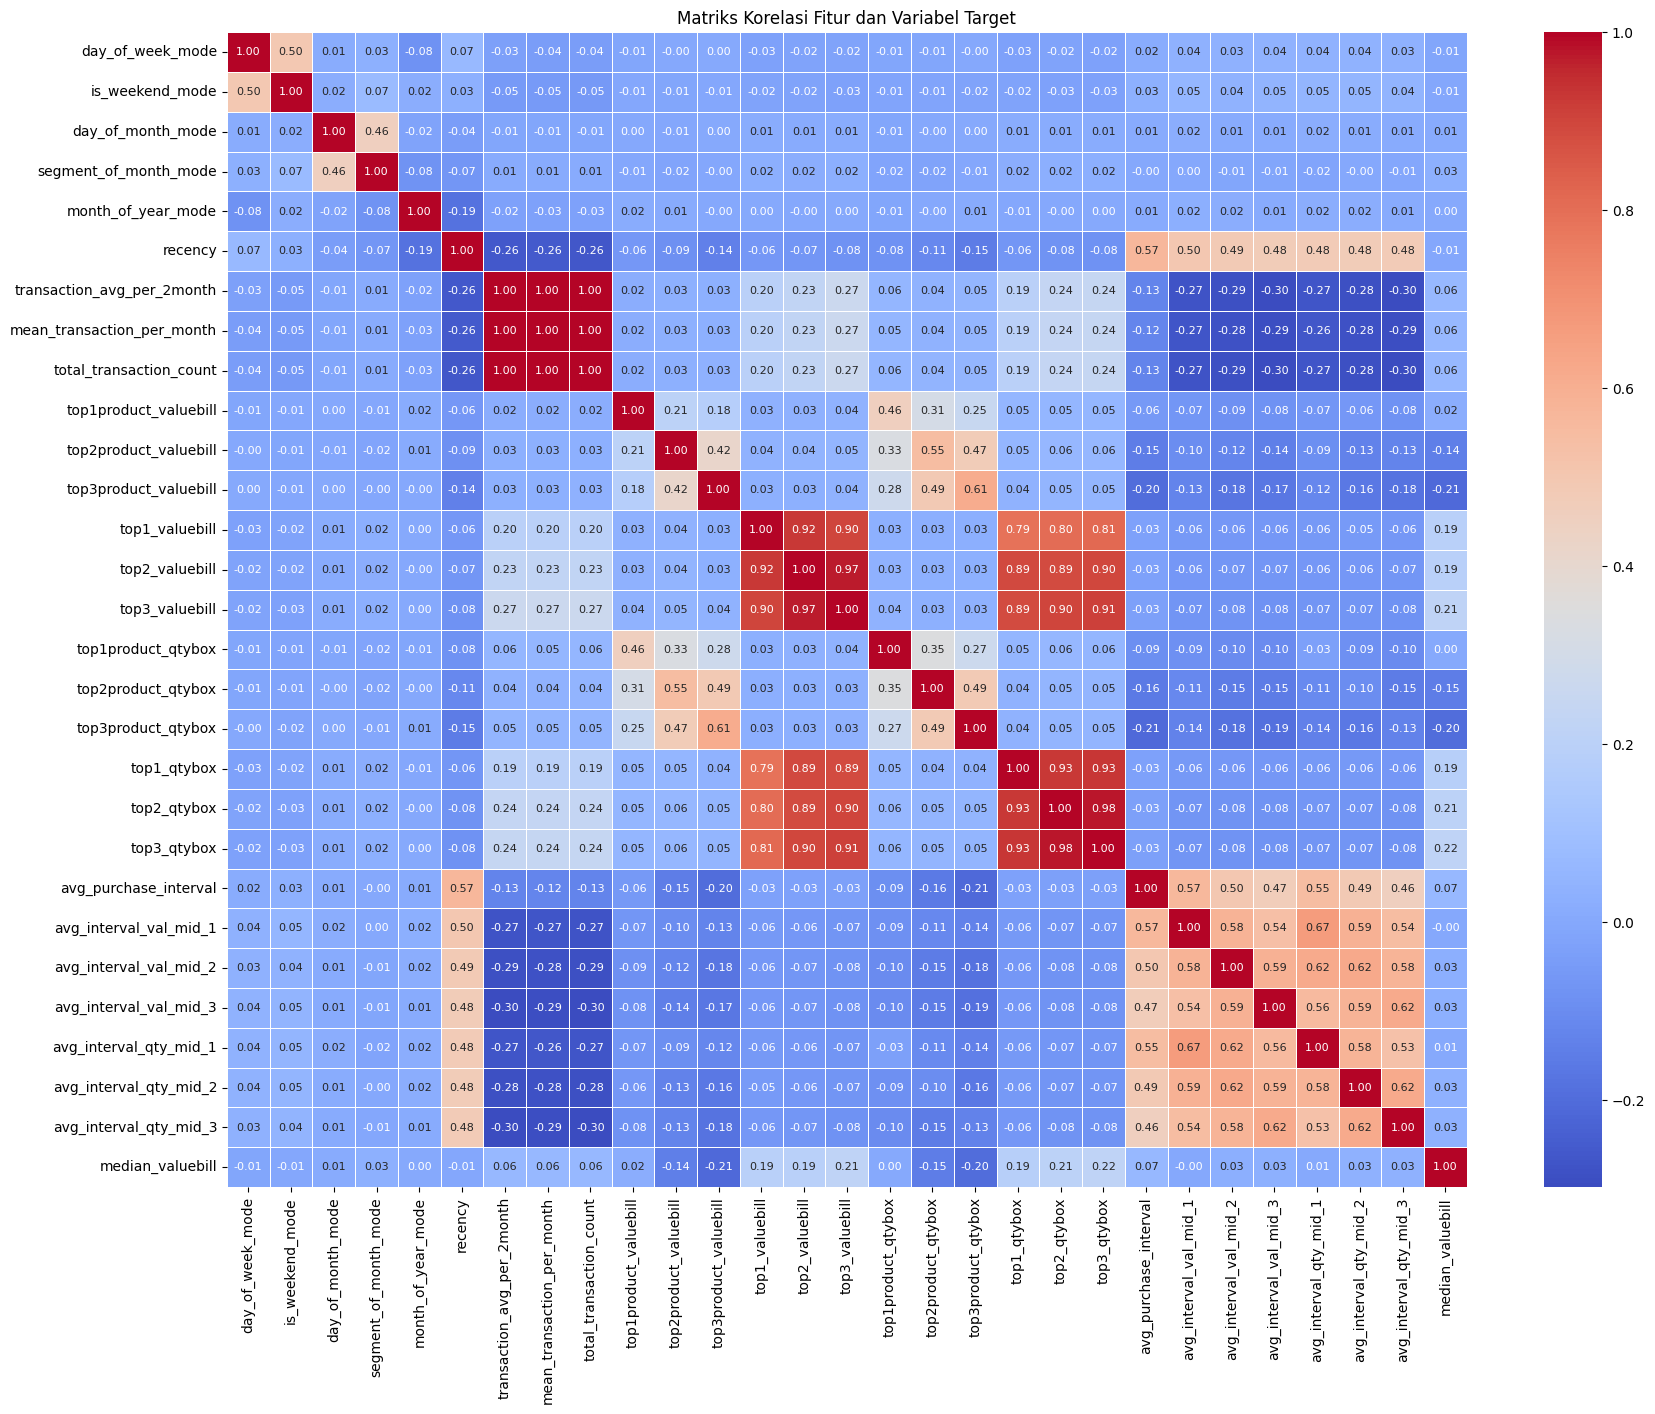

In [28]:
cust = pd.read_pickle('cust_extract_features.pkl')

numeric_features = [
       'day_of_week_mode', 'is_weekend_mode', 'day_of_month_mode',
       'segment_of_month_mode', 'month_of_year_mode', 'recency',
       'transaction_avg_per_2month', 'mean_transaction_per_month', 'total_transaction_count', 
       'top1product_valuebill', 'top2product_valuebill', 'top3product_valuebill', 
       'top1_valuebill', 'top2_valuebill', 'top3_valuebill', 
       'top1product_qtybox', 'top2product_qtybox', 'top3product_qtybox', 
       'top1_qtybox', 'top2_qtybox', 'top3_qtybox',
       'avg_purchase_interval', 
       'avg_interval_val_mid_1', 'avg_interval_val_mid_2', 'avg_interval_val_mid_3',
       'avg_interval_qty_mid_1', 'avg_interval_qty_mid_2', 'avg_interval_qty_mid_3'
]

target_variables = [
    'median_valuebill'
]

all_columns_for_correlation = numeric_features + target_variables
correlation_matrix = cust[all_columns_for_correlation].corr()

plt.figure(figsize=(20, 15))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    annot_kws={"size": 8}
)
plt.title('Matriks Korelasi Fitur dan Variabel Target')
plt.show()

In [29]:
correlation_results_dfs = []
for target in target_variables:
    correlation_series = correlation_matrix[target].sort_values(ascending=False)
    correlation_df = correlation_series.reset_index()
    correlation_df.columns = ['Feature', f'Correlation_with_{target}']
    correlation_results_dfs.append(correlation_df)

In [30]:
first_df = correlation_results_dfs[0].set_index('Feature')
combined_correlation_df = first_df
for i in range(1, len(correlation_results_dfs)):
    combined_correlation_df = combined_correlation_df.merge(
        correlation_results_dfs[i].set_index('Feature'),
        left_index=True,
        right_index=True,
        how='outer'
    )

In [31]:
for target in target_variables:
    print(f"\nKorelasi Fitur dengan Target '{target}':")
    print(correlation_matrix[target].sort_values(ascending=False))


Korelasi Fitur dengan Target 'median_valuebill':
median_valuebill              1.000000
top3_qtybox                   0.216529
top3_valuebill                0.214429
top2_qtybox                   0.207599
top1_valuebill                0.192216
top2_valuebill                0.191087
top1_qtybox                   0.187441
avg_purchase_interval         0.065951
total_transaction_count       0.064500
transaction_avg_per_2month    0.064225
mean_transaction_per_month    0.064018
avg_interval_qty_mid_3        0.034442
avg_interval_qty_mid_2        0.032322
segment_of_month_mode         0.030002
avg_interval_val_mid_3        0.029233
avg_interval_val_mid_2        0.025597
top1product_valuebill         0.021181
day_of_month_mode             0.008228
avg_interval_qty_mid_1        0.005168
month_of_year_mode            0.004679
top1product_qtybox            0.002525
avg_interval_val_mid_1       -0.002935
recency                      -0.005815
is_weekend_mode              -0.007502
day_of_week_mo

In [32]:
combined_correlation_df

,Correlation_with_median_valuebill
Feature,
median_valuebill,1.000000
top3_qtybox,0.216529
top3_valuebill,0.214429
top2_qtybox,0.207599
top1_valuebill,0.192216
top2_valuebill,0.191087
top1_qtybox,0.187441
avg_purchase_interval,0.065951
total_transaction_count,0.064500


# Customer Tree Based Model

In [19]:
cust = pd.read_pickle('cust_extract_features.pkl')

In [20]:
cust.head()

,real_customer_id,customer_id,customer_group,sls_office,channel,day_of_week_mode,is_weekend_mode,day_of_month_mode,segment_of_month_mode,month_of_year_mode,recency,transaction_avg_per_2month,mean_transaction_per_month,total_transaction_count,top1product_valuebill,top2product_valuebill,top3product_valuebill,top1_valuebill,top2_valuebill,top3_valuebill,top1product_qtybox,top2product_qtybox,top3product_qtybox,top1_qtybox,top2_qtybox,top3_qtybox,median_valuebill,avg_purchase_interval,avg_interval_val_mid_1,avg_interval_val_mid_2,avg_interval_val_mid_3,avg_interval_qty_mid_1,avg_interval_qty_mid_2,avg_interval_qty_mid_3
0,1002085,131074,Retail Large,Caringin,GT,4,0,8,1,11,5,822.0,390.00,1170,111019236,141117248,131310108,6310556.0,2756170.0,2292200.0,111019236,141010787,121411710,88.0,46.0,36.0,41400.0,0.074359,4.625000,4.071429,6.300000,4.625000,7.900000,6.666667
1,1002086,131078,WS 2,Caringin,GT,4,0,29,2,10,19,195.0,96.67,290,121411170,121611856,111019236,1326081.0,1319625.0,1224532.0,121411170,121611856,121410370,29.0,24.0,23.0,92898.0,0.248276,10.285714,10.833333,10.500000,10.285714,10.833333,9.000000
2,1002087,131080,WS 2,Caringin,GT,0,0,4,2,11,2,772.0,376.67,1130,141217128,141012060,141117248,6681502.0,5849672.0,5634970.0,141012060,141217128,141011985,310.0,230.0,200.0,101234.0,0.076991,6.461538,7.700000,8.750000,7.700000,6.461538,7.000000
3,1002972,131082,WS 2,Caringin,GT,0,0,18,2,12,1,1515.0,807.33,2422,141210977,111019236,141012060,21013704.0,20199480.0,15246884.0,141012060,141210977,141010324,808.0,664.0,608.0,112192.0,0.037159,5.928571,3.115385,5.142857,5.142857,5.928571,5.916667
4,1003148,131086,WS 2,Caringin,GT,4,0,4,2,12,5,200.5,101.67,305,111019236,141210977,141010787,4865798.0,2946548.0,2848862.0,141010787,141012060,141210977,150.0,130.0,90.0,175076.0,0.281967,12.000000,9.222222,9.500000,9.500000,10.857143,9.222222


In [21]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19216 entries, 0 to 19215
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   real_customer_id            19216 non-null  object 
 1   customer_id                 19216 non-null  int64  
 2   customer_group              19216 non-null  object 
 3   sls_office                  19216 non-null  object 
 4   channel                     19216 non-null  object 
 5   day_of_week_mode            19216 non-null  int32  
 6   is_weekend_mode             19216 non-null  int32  
 7   day_of_month_mode           19216 non-null  int32  
 8   segment_of_month_mode       19216 non-null  int32  
 9   month_of_year_mode          19216 non-null  int32  
 10  recency                     19216 non-null  int64  
 11  transaction_avg_per_2month  19216 non-null  float64
 12  mean_transaction_per_month  19216 non-null  float64
 13  total_transaction_count     192

In [22]:
cust.columns

Index(['real_customer_id', 'customer_id', 'customer_group', 'sls_office',
       'channel', 'day_of_week_mode', 'is_weekend_mode', 'day_of_month_mode',
       'segment_of_month_mode', 'month_of_year_mode', 'recency',
       'transaction_avg_per_2month', 'mean_transaction_per_month',
       'total_transaction_count', 'top1product_valuebill',
       'top2product_valuebill', 'top3product_valuebill', 'top1_valuebill',
       'top2_valuebill', 'top3_valuebill', 'top1product_qtybox',
       'top2product_qtybox', 'top3product_qtybox', 'top1_qtybox',
       'top2_qtybox', 'top3_qtybox', 'median_valuebill',
       'avg_purchase_interval', 'avg_interval_val_mid_1',
       'avg_interval_val_mid_2', 'avg_interval_val_mid_3',
       'avg_interval_qty_mid_1', 'avg_interval_qty_mid_2',
       'avg_interval_qty_mid_3'],
      dtype='object')

In [23]:
X = cust.drop(columns=['real_customer_id', 'customer_id', 'median_valuebill'])

non_numeric_cols = X.select_dtypes(exclude=['number']).columns.tolist()
print("Kolom non-numerik di X:", non_numeric_cols)

Kolom non-numerik di X: ['customer_group', 'sls_office', 'channel', 'top1product_valuebill', 'top2product_valuebill', 'top3product_valuebill', 'top1product_qtybox', 'top2product_qtybox', 'top3product_qtybox']


In [25]:
y = cust['median_valuebill']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
X_train[non_numeric_cols] = X_train[non_numeric_cols].astype(str)
X_test[non_numeric_cols] = X_test[non_numeric_cols].astype(str)

In [28]:
def plot_feature_importance(model, feature_names, model_name, top_n=15):
    importances = pd.Series(model.feature_importances_, index=feature_names)    
    top_features = importances.sort_values(ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 8))
    ax = top_features.plot(kind='barh', color='steelblue')
    plt.title(f"Top {top_n} Feature Importances - {model_name}", fontsize=16)
    plt.gca().invert_yaxis() 

    for i, (value, name) in enumerate(zip(top_features.values, top_features.index)):
        plt.text(value + 0.001, i, f" {value:.4f}", va='center', fontsize=10)

    plt.xlabel("Feature Importance", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.tight_layout()
    plt.show()

### Label Encoder

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15372 entries, 984 to 15795
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_group              15372 non-null  object 
 1   sls_office                  15372 non-null  object 
 2   channel                     15372 non-null  object 
 3   day_of_week_mode            15372 non-null  int32  
 4   is_weekend_mode             15372 non-null  int32  
 5   day_of_month_mode           15372 non-null  int32  
 6   segment_of_month_mode       15372 non-null  int32  
 7   month_of_year_mode          15372 non-null  int32  
 8   recency                     15372 non-null  int64  
 9   transaction_avg_per_2month  15372 non-null  float64
 10  mean_transaction_per_month  15372 non-null  float64
 11  total_transaction_count     15372 non-null  int64  
 12  top1product_valuebill       15372 non-null  object 
 13  top2product_valuebill       15372 

In [30]:
from sklearn.preprocessing import LabelEncoder

X_train_le = X_train.copy()
X_test_le = X_test.copy()

for col in non_numeric_cols:
    le = LabelEncoder()
    X_train_le[col] = le.fit_transform(X_train_le[col])
    
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    X_test_le[col] = X_test_le[col].map(mapping)
    X_test_le[col].fillna(-1, inplace=True) # Kalo ga ada di train

In [31]:
X_train_le.head(3)

,customer_group,sls_office,channel,day_of_week_mode,is_weekend_mode,day_of_month_mode,segment_of_month_mode,month_of_year_mode,recency,transaction_avg_per_2month,mean_transaction_per_month,total_transaction_count,top1product_valuebill,top2product_valuebill,top3product_valuebill,top1_valuebill,top2_valuebill,top3_valuebill,top1product_qtybox,top2product_qtybox,top3product_qtybox,top1_qtybox,top2_qtybox,top3_qtybox,avg_purchase_interval,avg_interval_val_mid_1,avg_interval_val_mid_2,avg_interval_val_mid_3,avg_interval_qty_mid_1,avg_interval_qty_mid_2,avg_interval_qty_mid_3
984,19,0,0,3,0,5,1,12,13,53.5,53.50,107,353,32,379,204661.0,83700.0,8.207700e+04,25,40,295,1.5,1.5,1.5,0.654206,28.000000,28.0,7.000000,28.000000,28.000000,28.0
439,30,0,0,2,0,26,1,10,2,956.0,503.33,1510,392,458,488,144816364.0,35434182.0,3.097399e+07,296,327,321,8120.0,1244.0,1204.0,0.058940,5.785714,6.9,4.428571,5.785714,5.714286,6.4
7273,22,0,0,3,0,19,2,12,13,9.0,9.00,9,29,298,213,55800.0,55800.0,4.800000e+04,28,151,223,1.0,1.0,1.0,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.0


In [32]:
X_test_le.head(3)

,customer_group,sls_office,channel,day_of_week_mode,is_weekend_mode,day_of_month_mode,segment_of_month_mode,month_of_year_mode,recency,transaction_avg_per_2month,mean_transaction_per_month,total_transaction_count,top1product_valuebill,top2product_valuebill,top3product_valuebill,top1_valuebill,top2_valuebill,top3_valuebill,top1product_qtybox,top2product_qtybox,top3product_qtybox,top1_qtybox,top2_qtybox,top3_qtybox,avg_purchase_interval,avg_interval_val_mid_1,avg_interval_val_mid_2,avg_interval_val_mid_3,avg_interval_qty_mid_1,avg_interval_qty_mid_2,avg_interval_qty_mid_3
6699,19,0,0,4,0,27,2,11,5,108.0,50.67,152,419.0,458.0,486.0,197600.0,170100.0,170100.0,320.0,327.0,353.0,7.0,5.0,5.0,0.552632,12.000000,14.000000,16.800000,12.000000,21.000000,14.000
2214,21,0,0,1,0,19,2,12,3,278.0,145.33,436,328.0,465.0,376.0,1029800.0,744358.0,696900.0,292.0,362.0,20.0,24.0,22.0,12.0,0.197248,6.750000,4.000000,5.500000,12.666667,4.000000,6.500
18530,31,1,0,0,0,14,1,12,1,933.0,483.33,1450,412.0,73.0,394.0,10551686.0,5618448.0,4701036.0,152.0,74.0,164.0,82.0,78.0,66.4,0.060690,3.545455,3.888889,5.571429,4.333333,3.888889,4.875


In [33]:
print(X_train_le.isna().sum().sum())
print(X_test_le.isna().sum().sum())

0
0


#### Random Forest

In [ ]:
%%time

rf_le  = RandomForestRegressor(random_state=42)

param_grid_le = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid_search_le = GridSearchCV(estimator=rf_le, param_grid=param_grid_le,
                           cv=3, n_jobs=-1, verbose=2)

print("Start GridSearchCV...")
grid_search_le.fit(X_train_le, y_train)

print("Best Params:")
print(grid_search_le.best_params_)

best_rf_model_le  = grid_search_le.best_estimator_
y_pred_rf_le  = best_rf_model_le .predict(X_test_le)

print("\nEvaluation:")
print(f"Label std: {y_test.std():,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf_le)):,.2f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred_rf_le):,.2f}")
print(f"R2  : {r2_score(y_test, y_pred_rf_le):.4f}")

Start GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Params:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Evaluation:
Label std: 252,169.22
RMSE: 146,957.95
MAE : 23,380.11
R2  : 0.6603
CPU times: total: 50.9 s
Wall time: 6min 15s


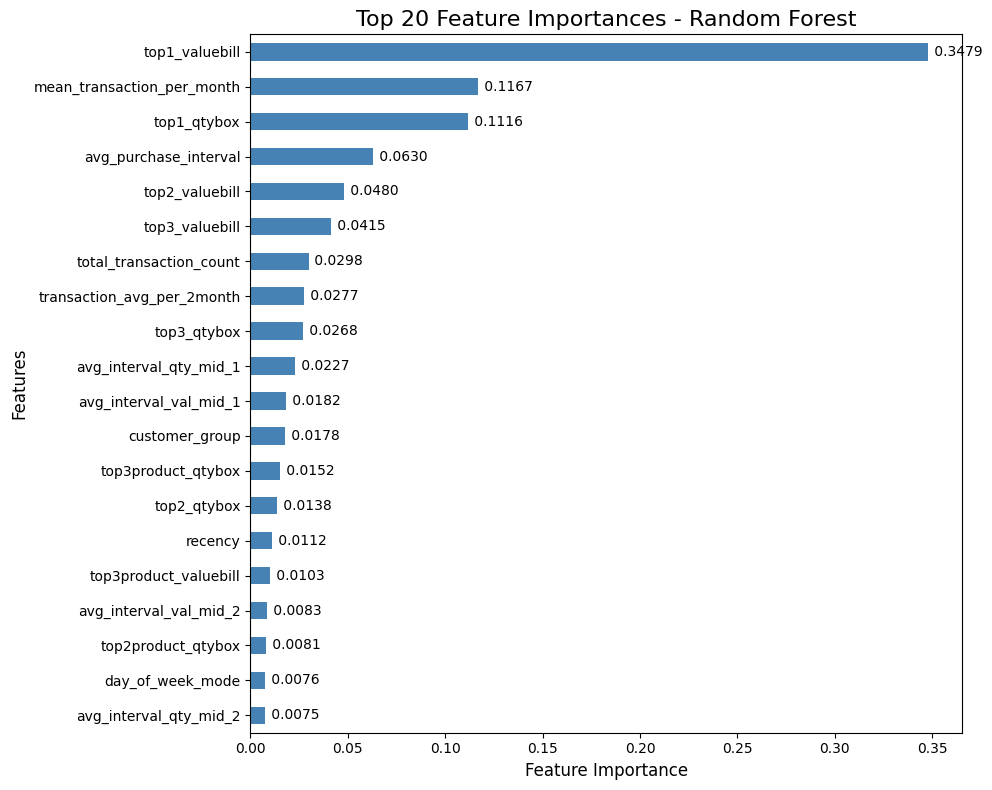

In [35]:
plot_feature_importance(model=best_rf_model_le, 
                        feature_names=X_train_le.columns, 
                        model_name="Random Forest",
                        top_n=20)

#### Gradient Boost

In [36]:
%%time

from sklearn.ensemble import GradientBoostingRegressor

gbr_le = GradientBoostingRegressor(random_state=42)

param_grid_gbr_le = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

grid_search_gbr_le = GridSearchCV(estimator=gbr_le, param_grid=param_grid_gbr_le,
                                  cv=3, n_jobs=-1, verbose=2)

print("Start GridSearchCV...")
grid_search_gbr_le.fit(X_train_le, y_train)

print("Best Params:")
print(grid_search_gbr_le.best_params_)

best_gbr_model_le = grid_search_gbr_le.best_estimator_
y_pred_gbr_le = best_gbr_model_le.predict(X_test_le)

print("\nEvaluation:")
print(f"Label std: {y_test.std():,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_gbr_le)):,.2f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred_gbr_le):,.2f}")
print(f"R2  : {r2_score(y_test, y_pred_gbr_le):.4f}")

Start GridSearchCV...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Params:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}

Evaluation:
Label std: 252,169.22
RMSE: 108,346.72
MAE : 25,120.94
R2  : 0.8153
CPU times: total: 12 s
Wall time: 1min 27s


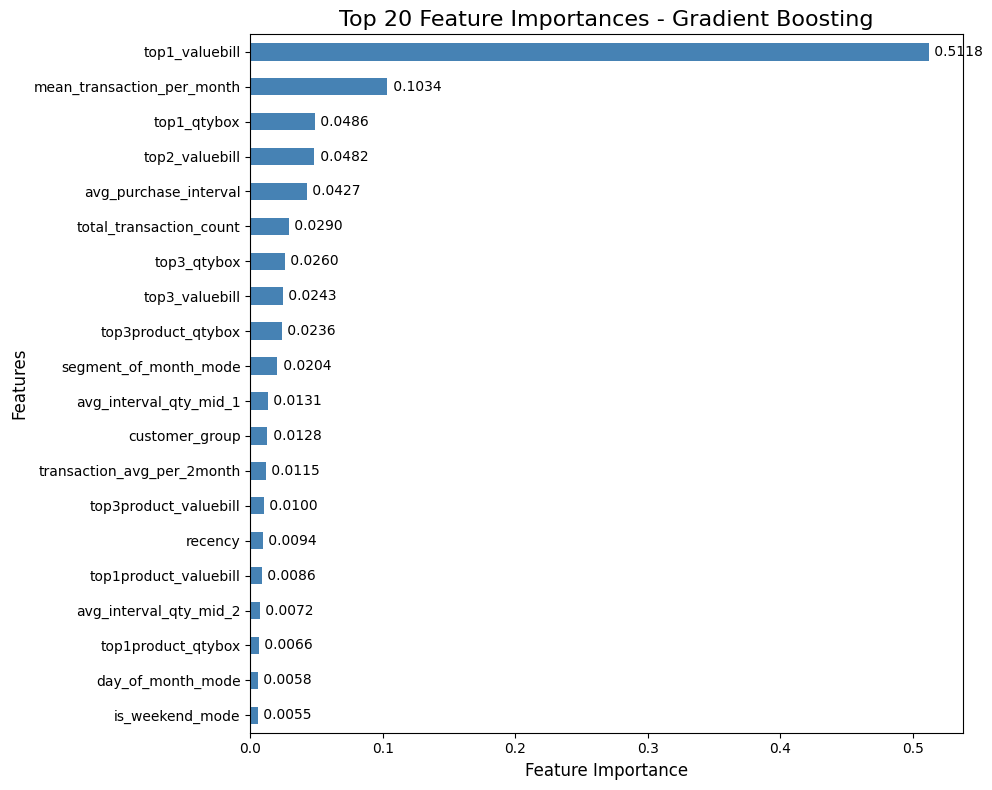

In [37]:
# Plot Feature Importance
plot_feature_importance(model=best_gbr_model_le,
                          feature_names=X_train_le.columns,
                          model_name="Gradient Boosting",
                          top_n=20)

#### XG Boost

In [38]:
%%time
from xgboost import XGBRegressor

xgb_le = XGBRegressor(random_state=42)

param_grid_xgb_le = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search_xgb_le = GridSearchCV(estimator=xgb_le, param_grid=param_grid_xgb_le,
                                  cv=3, n_jobs=-1, verbose=2)

print("Start GridSearchCV...")
grid_search_xgb_le.fit(X_train_le, y_train)

print("Best Params:")
print(grid_search_xgb_le.best_params_)

best_xgb_model_le = grid_search_xgb_le.best_estimator_
y_pred_xgb_le = best_xgb_model_le.predict(X_test_le)

print("\nEvaluation:")
print(f"Label std: {y_test.std():,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb_le)):,.2f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred_xgb_le):,.2f}")
print(f"R2  : {r2_score(y_test, y_pred_xgb_le):.4f}")

Start GridSearchCV...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Params:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}

Evaluation:
Label std: 252,169.22
RMSE: 116,381.31
MAE : 25,374.29
R2  : 0.7869
CPU times: total: 3.67 s
Wall time: 8.66 s


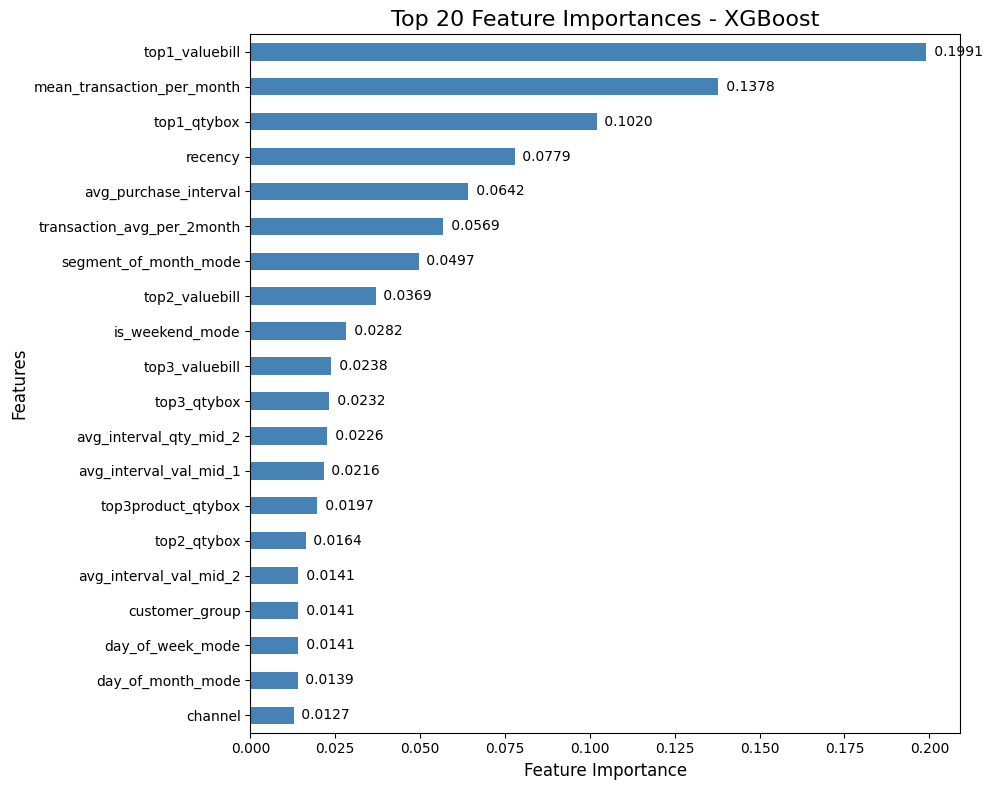

In [39]:
plot_feature_importance(model=best_xgb_model_le,
                          feature_names=X_train_le.columns,
                          model_name="XGBoost",
                          top_n=20)

#### Cat Boost

In [40]:
%%time

from catboost import CatBoostRegressor

cat_le = CatBoostRegressor(random_state=42, verbose=0)

param_grid_cat_le = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6]
}

grid_search_cat_le = GridSearchCV(estimator=cat_le, param_grid=param_grid_cat_le,
                                  cv=3, n_jobs=-1, verbose=2)

print("Start GridSearchCV...")
grid_search_cat_le.fit(X_train_le, y_train)

print("Best Params:")
print(grid_search_cat_le.best_params_)

best_cat_model_le = grid_search_cat_le.best_estimator_
y_pred_cat_le = best_cat_model_le.predict(X_test_le)

print("\nEvaluation:")
print(f"Label std: {y_test.std():,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_cat_le)):,.2f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred_cat_le):,.2f}")
print(f"R2  : {r2_score(y_test, y_pred_cat_le):.4f}")

Start GridSearchCV...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Params:
{'depth': 4, 'iterations': 200, 'learning_rate': 0.1}

Evaluation:
Label std: 252,169.22
RMSE: 110,651.06
MAE : 28,205.64
R2  : 0.8074
CPU times: total: 6.17 s
Wall time: 12.7 s


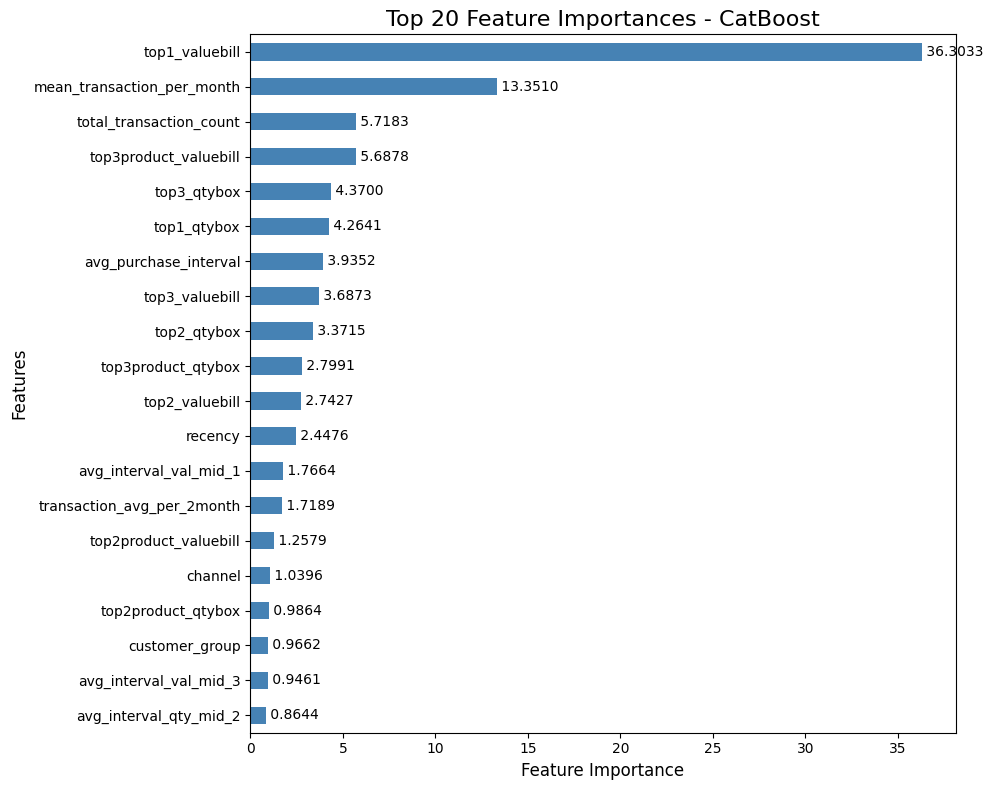

In [41]:
plot_feature_importance(model=best_cat_model_le,
                          feature_names=X_train_le.columns,
                          model_name="CatBoost",
                          top_n=20)

### Frequency Encoder

In [42]:
X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

for col in non_numeric_cols:
    freq_map = X_train_fe[col].value_counts(normalize=True).to_dict()
    
    X_train_fe[col] = X_train_fe[col].map(freq_map)
    X_test_fe[col] = X_test_fe[col].map(freq_map)
    
    X_test_fe[col].fillna(0, inplace=True) # Kalo ga ada di train

In [43]:
X_train_fe.head(3)

,customer_group,sls_office,channel,day_of_week_mode,is_weekend_mode,day_of_month_mode,segment_of_month_mode,month_of_year_mode,recency,transaction_avg_per_2month,mean_transaction_per_month,total_transaction_count,top1product_valuebill,top2product_valuebill,top3product_valuebill,top1_valuebill,top2_valuebill,top3_valuebill,top1product_qtybox,top2product_qtybox,top3product_qtybox,top1_qtybox,top2_qtybox,top3_qtybox,avg_purchase_interval,avg_interval_val_mid_1,avg_interval_val_mid_2,avg_interval_val_mid_3,avg_interval_qty_mid_1,avg_interval_qty_mid_2,avg_interval_qty_mid_3
984,0.489787,0.419529,0.975735,3,0,5,1,12,13,53.5,53.50,107,0.013791,0.004489,0.006961,204661.0,83700.0,8.207700e+04,0.047099,0.005595,0.002732,1.5,1.5,1.5,0.654206,28.000000,28.0,7.000000,28.000000,28.000000,28.0
439,0.016393,0.419529,0.975735,2,0,26,1,10,2,956.0,503.33,1510,0.127700,0.031095,0.023744,144816364.0,35434182.0,3.097399e+07,0.348361,0.072860,0.060239,8120.0,1244.0,1204.0,0.058940,5.785714,6.9,4.428571,5.785714,5.714286,6.4
7273,0.075202,0.419529,0.975735,3,0,19,2,12,13,9.0,9.00,9,0.004163,0.000976,0.000065,55800.0,55800.0,4.800000e+04,0.004163,0.000260,0.000716,1.0,1.0,1.0,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.0


In [44]:
X_test_fe.head(3)

,customer_group,sls_office,channel,day_of_week_mode,is_weekend_mode,day_of_month_mode,segment_of_month_mode,month_of_year_mode,recency,transaction_avg_per_2month,mean_transaction_per_month,total_transaction_count,top1product_valuebill,top2product_valuebill,top3product_valuebill,top1_valuebill,top2_valuebill,top3_valuebill,top1product_qtybox,top2product_qtybox,top3product_qtybox,top1_qtybox,top2_qtybox,top3_qtybox,avg_purchase_interval,avg_interval_val_mid_1,avg_interval_val_mid_2,avg_interval_val_mid_3,avg_interval_qty_mid_1,avg_interval_qty_mid_2,avg_interval_qty_mid_3
6699,0.489787,0.419529,0.975735,4,0,27,2,11,5,108.0,50.67,152,0.002537,0.031095,0.009693,197600.0,170100.0,170100.0,0.008587,0.072860,0.066289,7.0,5.0,5.0,0.552632,12.000000,14.000000,16.800000,12.000000,21.000000,14.000
2214,0.175904,0.419529,0.975735,1,0,19,2,12,3,278.0,145.33,436,0.004033,0.021988,0.010669,1029800.0,744358.0,696900.0,0.014117,0.030900,0.002862,24.0,22.0,12.0,0.197248,6.750000,4.000000,5.500000,12.666667,4.000000,6.500
18530,0.008002,0.315769,0.975735,0,0,14,1,12,1,933.0,483.33,1450,0.157754,0.069997,0.040333,10551686.0,5618448.0,4701036.0,0.013986,0.042024,0.011384,82.0,78.0,66.4,0.060690,3.545455,3.888889,5.571429,4.333333,3.888889,4.875


In [45]:
print(X_train_fe.isna().sum().sum())
print(X_test_fe.isna().sum().sum())

0
0


#### Random Forest

In [46]:
%%time

rf_fe = RandomForestRegressor(random_state=42)

param_grid_fe = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid_search_fe = GridSearchCV(estimator=rf_fe, param_grid=param_grid_fe,
                              cv=3, n_jobs=-1, verbose=2)

print("Start GridSearchCV...")
grid_search_fe.fit(X_train_fe, y_train)

print("Best Params:")
print(grid_search_fe.best_params_)

best_rf_model_fe = grid_search_fe.best_estimator_
y_pred_rf_fe = best_rf_model_fe.predict(X_test_fe)

print("\nEvaluation:")
print(f"Label std: {y_test.std():,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf_fe)):,.2f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred_rf_fe):,.2f}")
print(f"R2  : {r2_score(y_test, y_pred_rf_fe):.4f}")

Start GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Params:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Evaluation:
Label std: 252,169.22
RMSE: 153,409.73
MAE : 23,837.76
R2  : 0.6298
CPU times: total: 49.5 s
Wall time: 6min 8s


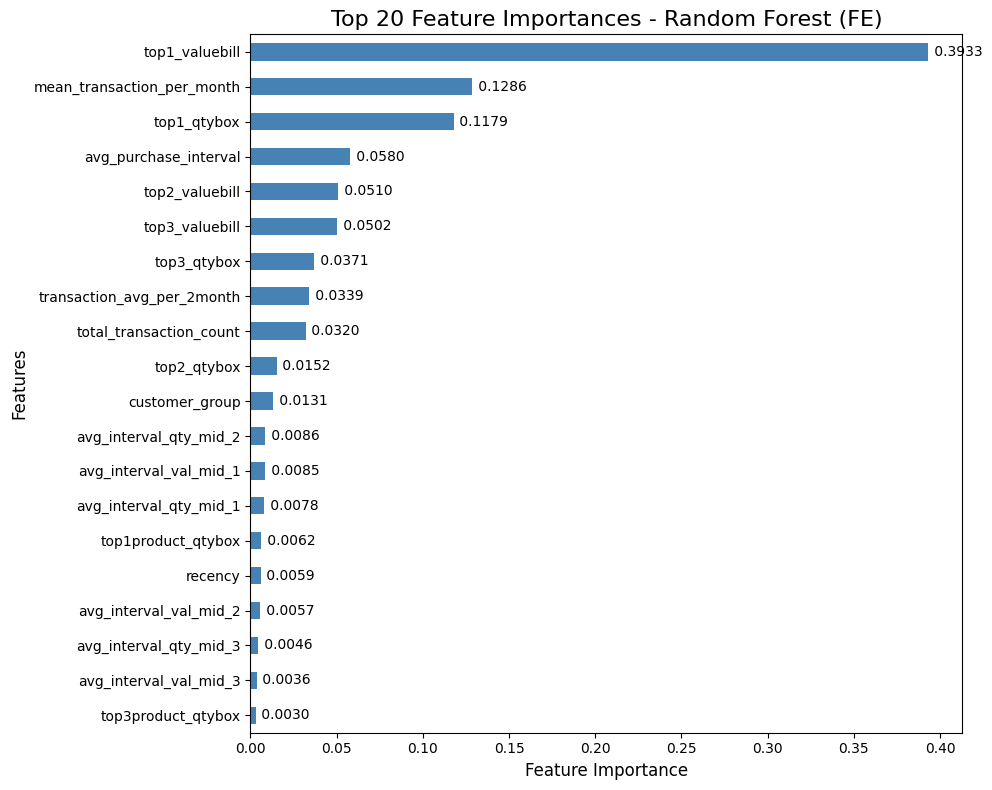

In [47]:
plot_feature_importance(model=best_rf_model_fe,
                          feature_names=X_train_fe.columns,
                          model_name="Random Forest (FE)",
                          top_n=20)

#### Gradient Boost

In [48]:
%%time 

from sklearn.ensemble import GradientBoostingRegressor

gbr_fe = GradientBoostingRegressor(random_state=42)

param_grid_gbr_fe = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

grid_search_gbr_fe = GridSearchCV(estimator=gbr_fe, param_grid=param_grid_gbr_fe,
                                  cv=3, n_jobs=-1, verbose=2)

print("Start GridSearchCV...")
grid_search_gbr_fe.fit(X_train_fe, y_train)

print("Best Params:")
print(grid_search_gbr_fe.best_params_)

best_gbr_model_fe = grid_search_gbr_fe.best_estimator_
y_pred_gbr_fe = best_gbr_model_fe.predict(X_test_fe)

print("\nEvaluation:")
print(f"Label std: {y_test.std():,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_gbr_fe)):,.2f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred_gbr_fe):,.2f}")
print(f"R2  : {r2_score(y_test, y_pred_gbr_fe):.4f}")

Start GridSearchCV...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Params:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}

Evaluation:
Label std: 252,169.22
RMSE: 108,531.41
MAE : 24,946.92
R2  : 0.8147
CPU times: total: 13.2 s
Wall time: 1min 29s


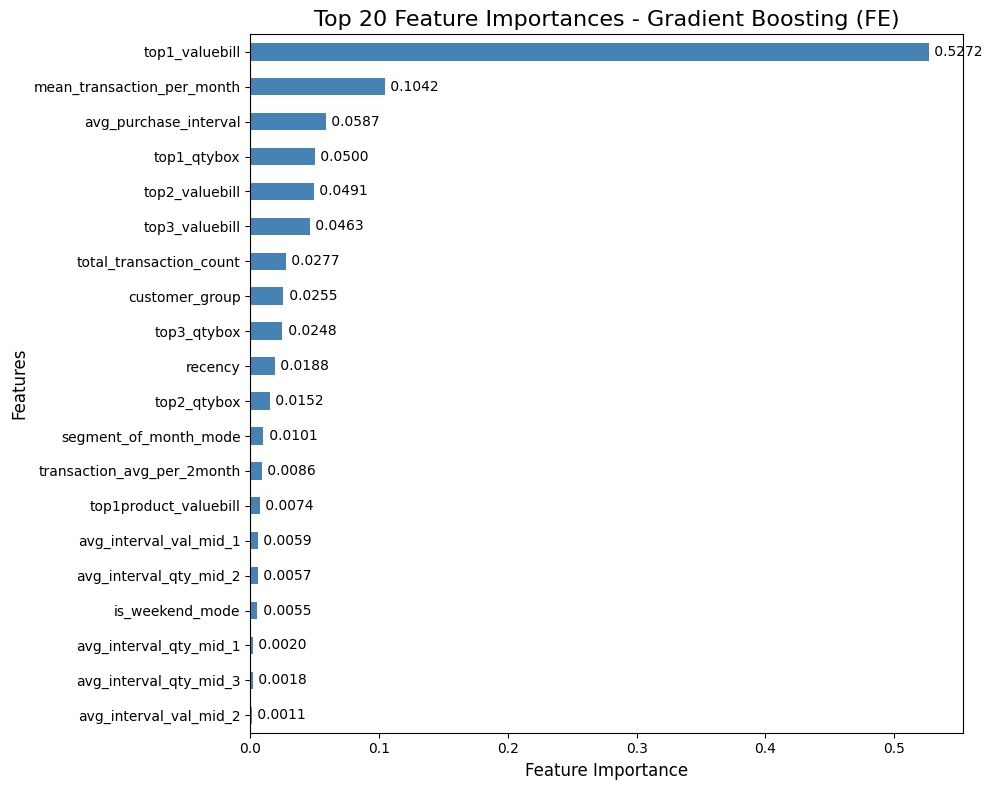

In [49]:
plot_feature_importance(model=best_gbr_model_fe,
                          feature_names=X_train_fe.columns,
                          model_name="Gradient Boosting (FE)",
                          top_n=20)

#### XG Boost

In [50]:
%%time

from xgboost import XGBRegressor

xgb_fe = XGBRegressor(random_state=42)

param_grid_xgb_fe = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search_xgb_fe = GridSearchCV(estimator=xgb_fe, param_grid=param_grid_xgb_fe,
                                  cv=3, n_jobs=-1, verbose=2)

print("Start GridSearchCV...")
grid_search_xgb_fe.fit(X_train_fe, y_train)

print("Best Params:")
print(grid_search_xgb_fe.best_params_)

best_xgb_model_fe = grid_search_xgb_fe.best_estimator_
y_pred_xgb_fe = best_xgb_model_fe.predict(X_test_fe)

print("\nEvaluation:")
print(f"Label std: {y_test.std():,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb_fe)):,.2f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred_xgb_fe):,.2f}")
print(f"R2  : {r2_score(y_test, y_pred_xgb_fe):.4f}")

Start GridSearchCV...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Params:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Evaluation:
Label std: 252,169.22
RMSE: 137,256.86
MAE : 27,028.10
R2  : 0.7037
CPU times: total: 4.06 s
Wall time: 7.87 s


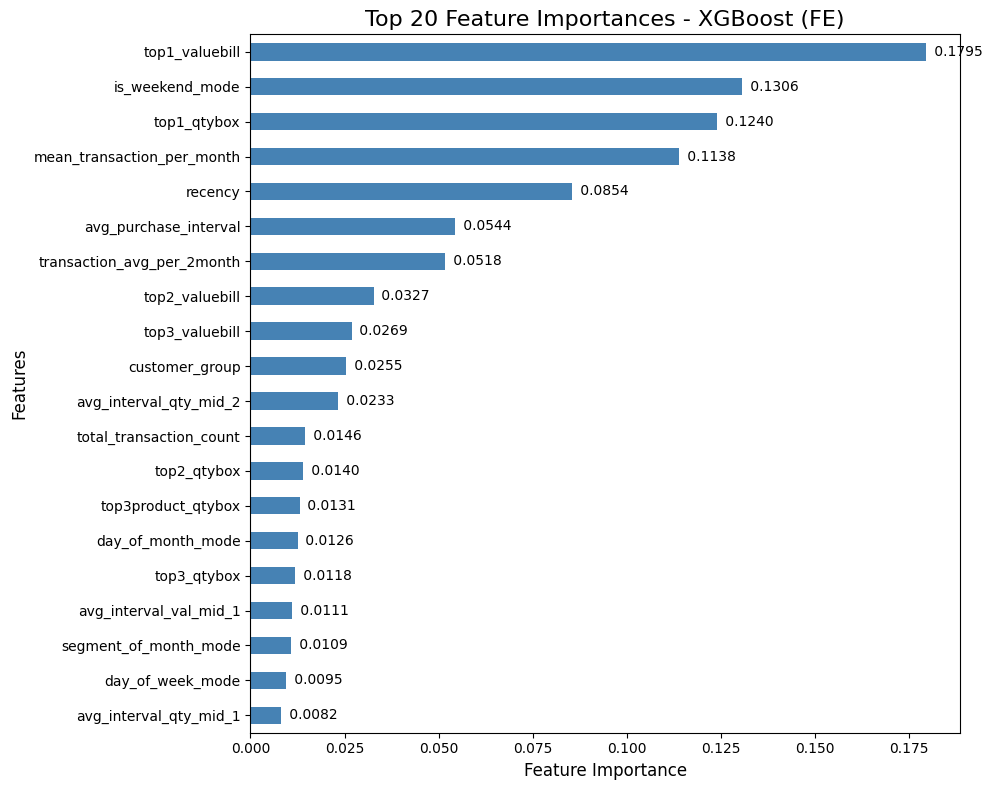

In [51]:
plot_feature_importance(model=best_xgb_model_fe,
                          feature_names=X_train_fe.columns,
                          model_name="XGBoost (FE)",
                          top_n=20)

#### Cat Boost

In [52]:
%%time

from catboost import CatBoostRegressor

cat_fe = CatBoostRegressor(random_state=42, verbose=0)

param_grid_cat_fe = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6]
}

grid_search_cat_fe = GridSearchCV(estimator=cat_fe, param_grid=param_grid_cat_fe,
                                  cv=3, n_jobs=-1, verbose=2)

print("Start GridSearchCV...")
grid_search_cat_fe.fit(X_train_fe, y_train)

print("Best Params:")
print(grid_search_cat_fe.best_params_)

best_cat_model_fe = grid_search_cat_fe.best_estimator_
y_pred_cat_fe = best_cat_model_fe.predict(X_test_fe)

print("\nEvaluation:")
print(f"Label std: {y_test.std():,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_cat_fe)):,.2f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred_cat_fe):,.2f}")
print(f"R2  : {r2_score(y_test, y_pred_cat_fe):.4f}")

Start GridSearchCV...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Params:
{'depth': 4, 'iterations': 200, 'learning_rate': 0.1}

Evaluation:
Label std: 252,169.22
RMSE: 120,678.03
MAE : 28,364.50
R2  : 0.7709
CPU times: total: 6.25 s
Wall time: 9.87 s


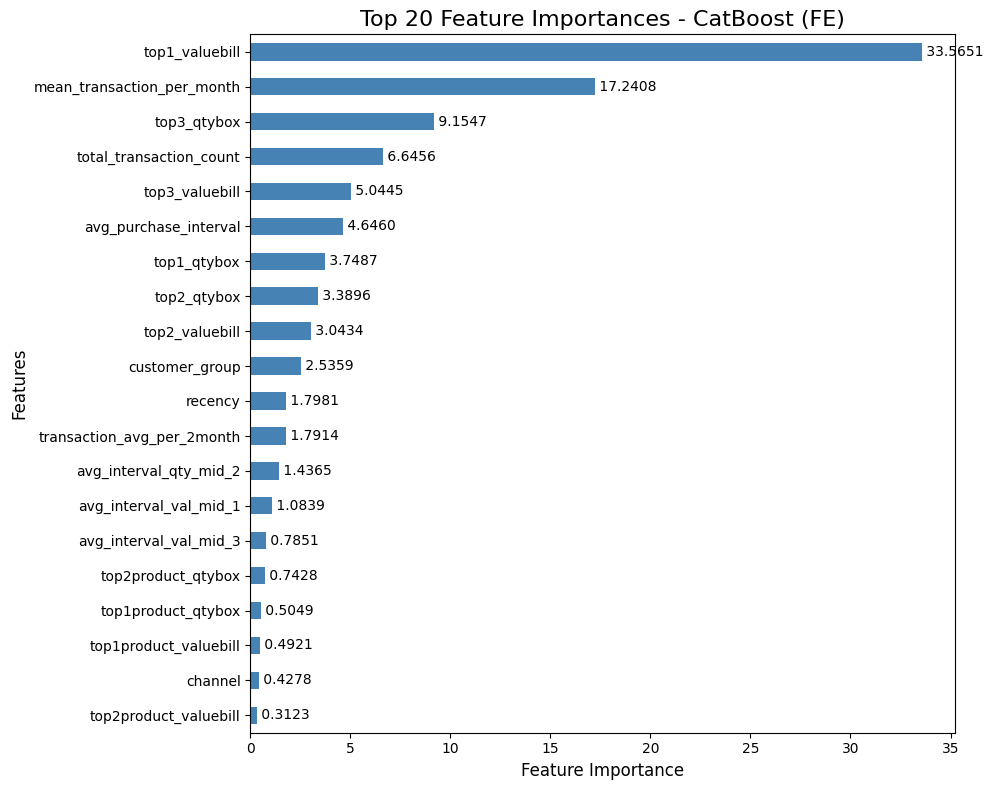

In [53]:
plot_feature_importance(model=best_cat_model_fe,
                          feature_names=X_train_fe.columns,
                          model_name="CatBoost (FE)",
                          top_n=20)

# Customer Selected Features

In [36]:
cust = pd.read_pickle('cust_extract_features.pkl')
cust.head()

,real_customer_id,customer_id,customer_group,sls_office,channel,day_of_week_mode,is_weekend_mode,day_of_month_mode,segment_of_month_mode,month_of_year_mode,recency,transaction_avg_per_2month,mean_transaction_per_month,total_transaction_count,top1product_valuebill,top2product_valuebill,top3product_valuebill,top1_valuebill,top2_valuebill,top3_valuebill,top1product_qtybox,top2product_qtybox,top3product_qtybox,top1_qtybox,top2_qtybox,top3_qtybox,median_valuebill,avg_purchase_interval,avg_interval_val_mid_1,avg_interval_val_mid_2,avg_interval_val_mid_3,avg_interval_qty_mid_1,avg_interval_qty_mid_2,avg_interval_qty_mid_3
0,1002085,131074,Retail Large,Caringin,GT,4,0,8,1,11,5,822.0,390.00,1170,111019236,141117248,131310108,6310556.0,2756170.0,2292200.0,111019236,141010787,121411710,88.0,46.0,36.0,41400.0,0.074359,4.625000,4.071429,6.300000,4.625000,7.900000,6.666667
1,1002086,131078,WS 2,Caringin,GT,4,0,29,2,10,19,195.0,96.67,290,121411170,121611856,111019236,1326081.0,1319625.0,1224532.0,121411170,121611856,121410370,29.0,24.0,23.0,92898.0,0.248276,10.285714,10.833333,10.500000,10.285714,10.833333,9.000000
2,1002087,131080,WS 2,Caringin,GT,0,0,4,2,11,2,772.0,376.67,1130,141217128,141012060,141117248,6681502.0,5849672.0,5634970.0,141012060,141217128,141011985,310.0,230.0,200.0,101234.0,0.076991,6.461538,7.700000,8.750000,7.700000,6.461538,7.000000
3,1002972,131082,WS 2,Caringin,GT,0,0,18,2,12,1,1515.0,807.33,2422,141210977,111019236,141012060,21013704.0,20199480.0,15246884.0,141012060,141210977,141010324,808.0,664.0,608.0,112192.0,0.037159,5.928571,3.115385,5.142857,5.142857,5.928571,5.916667
4,1003148,131086,WS 2,Caringin,GT,4,0,4,2,12,5,200.5,101.67,305,111019236,141210977,141010787,4865798.0,2946548.0,2848862.0,141010787,141012060,141210977,150.0,130.0,90.0,175076.0,0.281967,12.000000,9.222222,9.500000,9.500000,10.857143,9.222222


In [37]:
# Filter-In Features with FE > 0.01
cust = cust[['real_customer_id',
             'customer_id', 
             'top1product_valuebill', 
             'mean_transaction_per_month',
             'top1_qtybox',
             'top2_valuebill',
             'avg_purchase_interval',
             'total_transaction_count',
             'top3_qtybox',
             'top3_valuebill',
             'top3product_qtybox',
             'segment_of_month_mode',
             'avg_interval_qty_mid_1',
             'customer_group',
             'transaction_avg_per_2month',
             'top3product_valuebill']].copy()

In [38]:
cust.head()

,real_customer_id,customer_id,top1product_valuebill,mean_transaction_per_month,top1_qtybox,top2_valuebill,avg_purchase_interval,total_transaction_count,top3_qtybox,top3_valuebill,top3product_qtybox,segment_of_month_mode,avg_interval_qty_mid_1,customer_group,transaction_avg_per_2month,top3product_valuebill
0,1002085,131074,111019236,390.00,88.0,2756170.0,0.074359,1170,36.0,2292200.0,121411710,1,4.625000,Retail Large,822.0,131310108
1,1002086,131078,121411170,96.67,29.0,1319625.0,0.248276,290,23.0,1224532.0,121410370,2,10.285714,WS 2,195.0,111019236
2,1002087,131080,141217128,376.67,310.0,5849672.0,0.076991,1130,200.0,5634970.0,141011985,2,7.700000,WS 2,772.0,141117248
3,1002972,131082,141210977,807.33,808.0,20199480.0,0.037159,2422,608.0,15246884.0,141010324,2,5.142857,WS 2,1515.0,141012060
4,1003148,131086,111019236,101.67,150.0,2946548.0,0.281967,305,90.0,2848862.0,141210977,2,9.500000,WS 2,200.5,141010787


In [40]:
cust.to_pickle('cust_selected_features.pkl')

# Product Extract Features

In [ ]:
full_product = pd.read_pickle('data/full_product.pkl')
full_product.head()

In [14]:
full_product['base_uom'].value_counts()

base_uom
BOX    1471
PCS      30
Name: count, dtype: int64

In [24]:
full_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1561 entries, 0 to 1560
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   real_mid         1561 non-null   int32  
 1   mid              1561 non-null   object 
 2   mid_desc         1561 non-null   object 
 3   desc1            1561 non-null   object 
 4   desc2            1561 non-null   object 
 5   mg2_desc         1561 non-null   object 
 6   rate_unit        1501 non-null   object 
 7   cond_price_unit  1501 non-null   float64
 8   base_uom         1501 non-null   object 
 9   rate_avg         1501 non-null   float64
 10  ukuran           1292 non-null   float64
 11  satuan           1290 non-null   object 
dtypes: float64(3), int32(1), object(8)
memory usage: 140.4+ KB


### Fill NaN

In [25]:
full_product['rate_unit'].value_counts()

rate_unit
IDR    1501
Name: count, dtype: int64

In [26]:
full_product['base_uom'].value_counts()

base_uom
BOX    1471
PCS      30
Name: count, dtype: int64

In [27]:
full_product['satuan'].value_counts()

satuan
ML     779
GR     504
SHT      7
Name: count, dtype: int64

In [28]:
full_product['rate_unit'] = full_product['rate_unit'].fillna('IDR')
full_product['cond_price_unit'] = full_product['cond_price_unit'].fillna(0)
full_product['base_uom'] = full_product['base_uom'].fillna('Unknown')
full_product['rate_avg'] = full_product['rate_avg'].fillna(0)
full_product['ukuran'] = full_product['ukuran'].fillna(0)
full_product['satuan'] = full_product['satuan'].fillna('Unknown')

In [29]:
full_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1561 entries, 0 to 1560
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   real_mid         1561 non-null   int32  
 1   mid              1561 non-null   object 
 2   mid_desc         1561 non-null   object 
 3   desc1            1561 non-null   object 
 4   desc2            1561 non-null   object 
 5   mg2_desc         1561 non-null   object 
 6   rate_unit        1561 non-null   object 
 7   cond_price_unit  1561 non-null   float64
 8   base_uom         1561 non-null   object 
 9   rate_avg         1561 non-null   float64
 10  ukuran           1561 non-null   float64
 11  satuan           1561 non-null   object 
dtypes: float64(3), int32(1), object(8)
memory usage: 140.4+ KB


### Product Popularity

#### Customer

Menghitung berapa banyak customer unik yang membeli produk tertentu

In [30]:
order_cust = pd.read_pickle('order_cust.pkl')

In [31]:
popular_products = order_cust.groupby(['real_mid'])['customer_id'].nunique().reset_index(name='n_cust')
popular_products['real_mid'] = popular_products['real_mid'].astype('int32')
full_product = full_product.merge(popular_products, on=['real_mid'], how='left')

In [32]:
full_product.head()

,real_mid,mid,mid_desc,desc1,desc2,mg2_desc,rate_unit,cond_price_unit,base_uom,rate_avg,ukuran,satuan,n_cust
0,61800,111616385,FN COLOGNE DESSERT VIOLET BTL 100ML,PERSONAL CARE,COLOGNE,COLOGNE SPRAY FRES&NATURAL BTL100ML24PCS,IDR,24.0,BOX,250911.856000,100.0,ML,1309.0
1,20322,131216387,SEDAAP MIE GORENG AYAM BAKAR LIMAU 89Gr,FOOD,NOODLES,NOODLE SEDAAPMIE GORENG 40PCS 91GR,IDR,40.0,BOX,114053.693750,91.0,GR,909.0
2,1061830,121616390,DAIA POWDET CLEAN&FRESH BAG 800GR NPRG,FABRIC CARE,POWDER DETERGENT,POWDET DAIA BAG 12PCS 800GR NPRG,IDR,12.0,BOX,196200.000000,800.0,GR,1620.0
3,1060153,121116393,SOKLIN PEMUTIH REGULAR BTL 500ML,FABRIC CARE,BLEACHING,BLEACHING SOKLIN BOTTLE 12PCS 500ML,IDR,12.0,BOX,73317.345333,500.0,ML,150.0
4,61229,141016395,ALE-ALE GUAVA CUP 180ML,BEVERAGE,CUP RTD,FOODRTD ALE-ALE CUP 200ML 24PCS,IDR,24.0,BOX,19750.000000,200.0,ML,4420.0


### Transaction, Qty, Value_Bill

1. total_sales_count (Frekuensi Penjualan Produk)
    - Fitur ini bertujuan melihat seberapa sering suatu produk dibeli. Ini membantu mengidentifikasi produk yang paling sering muncul dalam transaksi, tidak peduli berapa banyak kuantitas atau nilai penjualannya. Misalnya, produk X terjual 1000 kali, sementara produk Y hanya 100 kali. Produk X lebih sering dibeli.

2. total_qty_sold (Volume Penjualan Produk)
    - Fitur ini bertujuan melihat berapa banyak total unit/kuantitas dari suatu produk yang berhasil terjual. Ini membantu mengidentifikasi produk yang memiliki volume penjualan tertinggi. Sebuah produk mungkin tidak sering terjual (total_sales_count rendah), tetapi setiap kali terjual, kuantitasnya sangat besar (total_qty_sold tinggi), menunjukkan itu adalah produk pembelian grosir atau dalam jumlah besar.

3. total_revenue (Kontribusi Pendapatan Produk) 
    - Fitur ini bertujuan melihat berapa banyak total uang yang dihasilkan oleh suatu produk. Ini membantu mengidentifikasi produk mana yang paling berkontribusi terhadap pendapatan keseluruhan bisnis Anda. Produk ini bisa jadi tidak terlalu sering terjual atau tidak dalam kuantitas besar, tetapi harganya sangat tinggi, sehingga memberikan kontribusi pendapatan yang signifikan.

In [33]:
product_popularity_from_orders = order_cust.groupby('real_mid').agg(
    total_sales_count=('date_id', 'size'),   # Total berapa kali MID ini terjual
    total_qty_sold=('qty_box', 'sum'),       # Total kuantitas MID ini terjual
    total_revenue=('value_bill', 'sum')      # Total pendapatan MID ini
).reset_index()

product_popularity_from_orders['real_mid'] = product_popularity_from_orders['real_mid'].astype('int32')

full_product = pd.merge(full_product, product_popularity_from_orders, on='real_mid', how='left')

In [34]:
full_product.head()

,real_mid,mid,mid_desc,desc1,desc2,mg2_desc,rate_unit,cond_price_unit,base_uom,rate_avg,ukuran,satuan,n_cust,total_sales_count,total_qty_sold,total_revenue
0,61800,111616385,FN COLOGNE DESSERT VIOLET BTL 100ML,PERSONAL CARE,COLOGNE,COLOGNE SPRAY FRES&NATURAL BTL100ML24PCS,IDR,24.0,BOX,250911.856000,100.0,ML,1309.0,3067.0,807.754,1.850444e+08
1,20322,131216387,SEDAAP MIE GORENG AYAM BAKAR LIMAU 89Gr,FOOD,NOODLES,NOODLE SEDAAPMIE GORENG 40PCS 91GR,IDR,40.0,BOX,114053.693750,91.0,GR,909.0,2147.0,3707.425,3.960111e+08
2,1061830,121616390,DAIA POWDET CLEAN&FRESH BAG 800GR NPRG,FABRIC CARE,POWDER DETERGENT,POWDET DAIA BAG 12PCS 800GR NPRG,IDR,12.0,BOX,196200.000000,800.0,GR,1620.0,3275.0,3209.186,5.940424e+08
3,1060153,121116393,SOKLIN PEMUTIH REGULAR BTL 500ML,FABRIC CARE,BLEACHING,BLEACHING SOKLIN BOTTLE 12PCS 500ML,IDR,12.0,BOX,73317.345333,500.0,ML,150.0,320.0,271.591,1.923183e+07
4,61229,141016395,ALE-ALE GUAVA CUP 180ML,BEVERAGE,CUP RTD,FOODRTD ALE-ALE CUP 200ML 24PCS,IDR,24.0,BOX,19750.000000,200.0,ML,4420.0,14615.0,189346.000,3.561182e+09


In [35]:
full_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1561 entries, 0 to 1560
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   real_mid           1561 non-null   int32  
 1   mid                1561 non-null   object 
 2   mid_desc           1561 non-null   object 
 3   desc1              1561 non-null   object 
 4   desc2              1561 non-null   object 
 5   mg2_desc           1561 non-null   object 
 6   rate_unit          1561 non-null   object 
 7   cond_price_unit    1561 non-null   float64
 8   base_uom           1561 non-null   object 
 9   rate_avg           1561 non-null   float64
 10  ukuran             1561 non-null   float64
 11  satuan             1561 non-null   object 
 12  n_cust             1139 non-null   float64
 13  total_sales_count  1139 non-null   float64
 14  total_qty_sold     1139 non-null   float64
 15  total_revenue      1139 non-null   float64
dtypes: float64(7), int32(1),

In [36]:
full_product.fillna(0, inplace=True)

In [37]:
full_product.columns

Index(['real_mid', 'mid', 'mid_desc', 'desc1', 'desc2', 'mg2_desc',
       'rate_unit', 'cond_price_unit', 'base_uom', 'rate_avg', 'ukuran',
       'satuan', 'n_cust', 'total_sales_count', 'total_qty_sold',
       'total_revenue'],
      dtype='object')

In [38]:
full_product.to_pickle('product_extract_features.pkl')